<h1><center>BIO-INFORMATICS 2018</center></h1>
<h2><center>Homework 2 - Neuroscience application</center></h2>

## Team 3:

** Alikana Pavan Kumar (1826777)**

** Dudekula Dastagiri (1826239)**

** Gunturi Vamsi Krishna Varma (1794653)**

# Table of Contents

[Loading Python Libraries](#0)

[Loading Utilities](#1)

[Dataset](#2)
     
[Data Modelling](#3)
   
[Connectivity Graph](#4)
    
[Graph theory indices](#5)

## Loading required Python Libraries <a name="0"></a>

In [58]:
#Loading required libraries

from mpl_toolkits.mplot3d import Axes3D
from scipy import signal, special
import matplotlib.pyplot as plt
import connectivipy as cp
import scipy.stats as st 
import networkx as nx
import pandas as pd
import numpy as np
import pyedflib
#import igraph as ig
#import louvain
#import igraph as ig
import copy
import json

import warnings
warnings.filterwarnings('ignore')

import seaborn as sbs

from os.path import join as pjoin
import os
from pathlib import Path

# Path to the current working directory to refer to all the files relatively
my_path = os.path.dirname(os.path.realpath('__file__'))

## Loading Utilities <a name="1"></a>

### Utilities for Graph plotting

In [59]:
# Common functions for plotting
def plot_topology(g, g_index, s_index, d_text):
    
    plot_title = graph_title(g_index, s_index, d_text, "")
    
    plot_fullpath = graph_path(g_index, s_index, d_text, True)
    
    plt.figure(figsize=(5,5)) 
    nx.draw_networkx(g, position_data, arrows=True, edge_color="grey", node_color="blue", 
                     node_size=400, font_size=9, font_color="white")
    plt.title(plot_title)
    plt.savefig(plot_fullpath, format="png")
    plt.show()
    
    
def plot_adjacency_matrix(m, g_index, s_index, d_text):
    
    plot_title = graph_title(g_index, s_index, d_text, "")
    
    plot_fullpath = graph_path(g_index, s_index, d_text, False)
    
    fig = plt.figure(figsize=(5, 5)) # in inches
    plt.imshow(m, cmap="plasma", interpolation="none")
    plt.title(plot_title)
    plt.savefig(plot_fullpath, format="png")
    plt.show()
    
    
def graph_title(g_index, s_index, d_text, title_head):
    g_types = ['DTF', 'PDC']
    s_types = ['EO', 'EC']
    title_middle_1 = " using "
    title_middle_2 = " with density "
    title_tail = " %"
    
    title = title_head + s_types[s_index] + title_middle_1 + g_types[g_index] + title_middle_2 + d_text + title_tail
    
    return title


def graph_path(g_index, s_index, d_text, dirFlag):
    
    dir_path = ""
    file_name = ""
    
    if(g_index == 0):
        if(s_index == 0):
            file_name = "/DTF_EO"
            
            if(dirFlag): 
                dir_path = t_dtf_eo_dir
            else:
                dir_path = am_dtf_eo_dir
        else:
            file_name = "/DTF_EC"
            
            if(dirFlag): 
                dir_path = t_dtf_ec_dir
            else:
                dir_path = am_dtf_ec_dir
                
    else:
        if(s_index == 0):
            file_name = "/PDC_EO"
            
            if(dirFlag): 
                dir_path = t_pdc_eo_dir
            else:
                dir_path = am_pdc_eo_dir
            
        else:
            file_name = "/PDC_EC"
            
            if(dirFlag): 
                dir_path = t_pdc_ec_dir
            else:
                dir_path = am_pdc_ec_dir
    
    return dir_path + file_name + "_" + d_text + '.png'

### Utilities for Signal analysis

In [60]:
# Utils for Signal analysis from EEG data and build correponding models using Numpy arrays

def extractSignal(f):
    n = f.signals_in_file
    signal_labels = f.getSignalLabels()
    sigbufs = np.zeros((n, f.getNSamples()[0]))
    for i in np.arange(n):
        sigbufs[i, :] = f.readSignal(i)
    return sigbufs

def signal_routine(EO, EC):
    signal_EO=extractSignal(EO)
    signal_EC=extractSignal(EC)
    n, m = signal_EO.shape
    signals=np.zeros((n, m, 2))
    signals[:,:,0] = signal_EO[:]
    signals[:,:,1] = signal_EC[:]
    
    logic1=(signals[:,:,0] == signal_EO).mean()
    logic2=(signals[:,:,1] == signal_EC).mean()
    return signals


# Code from http://pyedflib.readthedocs.io/en/latest
def signal_matrix_from_eeg(filename):
    
    f = pyedflib.EdfReader(filename)
    
    k, N = f.signals_in_file, f.getNSamples()[0]
           
    sigbufs = np.zeros((k, N, 1))
    for i in np.arange(k):
        sigbufs[i, :, 0] = f.readSignal(i)
        
    return sigbufs, f.getSampleFrequency(0), f.getSignalLabels()


def select_relevant_channel(signals, frequency, indexes, nps=160):
    channel_of_interest, best_frequency, max_pxx = 0, 0, 0
    for i in indexes:
        f, Pxx_den = signal.welch(x=signals[i, :, 0], fs=frequency, nperseg=nps)
        alpha_interest = np.where((f >= 8) & (f <= 13))
        best_index = np.argmax(Pxx_den[alpha_interest[0]])+8

        if max(max_pxx, Pxx_den[best_index]) > max_pxx:
            max_pxx = Pxx_den[best_index]
            channel_of_interest = i
            best_frequency = f[best_index]
    return channel_of_interest, best_frequency


### Utilities for Connectivity Graph

In [61]:
# Utils for Connectivity graph

def find_best_alpha(interest, desired_density=0.2, tol=1e-3, N=64, n_iter=100, debug=False):
    search_space = [0.0, 1.0]
    density, i = 0, 0
    best_alpha, this_alpha, best_n = -1, 0, 4096
    target = int(N*(N-1)*desired_density)
   
    if debug:
        print("Desired number of nodes: {} for desired density {}".format(target, desired_density))
    
    while best_alpha != this_alpha:
        best_alpha = this_alpha
        for alpha in np.arange(search_space[0], search_space[1], (search_space[1] - search_space[0])/100.0):
            n = len(np.where(interest > alpha)[0])
            if abs(n-target) < abs(best_n-target) and n-target>0:
                this_alpha, best_n = alpha, n
        if debug:
            print("In search_space({:0.3f},{:0.3f}) alpha: {:0.3f} best_n: {} proportion: {:0.3f}".format(search_space[0], 
                                                                                                       search_space[1], 
                                                                                                       this_alpha, 
                                                                                                       best_n, 
                                                                                                       best_n/(N*(N-1))))
        search_space[0], search_space[1] = this_alpha-tol, this_alpha+tol

    return best_alpha


def create_edges_list(input_matrix, alpha, weighted=False):
    x, y = np.where(input_matrix > alpha)
        
    if weighted:
        return list(zip(map(lambda idx: dict_names[idx], x), 
                        map(lambda idy: dict_names[idy], y), 
                        map(lambda x: input_matrix[x[0]][x[1]], list(zip(x, y))))) 
    else:
        return list(zip(map(lambda idx: dict_names[idx], x), map(lambda idy: dict_names[idy], y)))

def create_directed_graph(input_matrix, alpha, position, weighted=False):
    G = nx.DiGraph()
    G.add_nodes_from(position_data.keys(), style='filled',fillcolor='red', pos=position, nodesize=10)
    
    if weighted:
        G = nx.DiGraph((x, y, {'weight':w}) for (x, y, w) in create_edges_list(input_matrix, alpha, weighted=True))
    else:
        G.add_edges_from(create_edges_list(input_matrix, alpha))
    
    return G

def create_position_graph(filename):    
    location = pd.read_csv(filename, sep="\t", encoding='latin-1', index_col=0)
    position_data = {label.replace('.', ''): (x, y) for label, x, y in zip(location['label'], location['x'], location['y'])}
    
    return position_data

def create_adjacency_matrix(interest, alpha):
    return np.array(interest > alpha, dtype=np.int)


## Utilities for Graph theory indices

In [62]:
def gi_path(path_meta):
    
    dir_path = ""
    file_name = ""
    
    i_index = path_meta[0]
    g_index = path_meta[1]
    s_index = path_meta[2]
    d_text = path_meta[3]
    
    
    if(i_index == 0):
    
        if(g_index == 0):
            if(s_index == 0):
                file_name = "/DTF_EO"

                dir_path = gid_dtf_eo_dir
                
            else:
                file_name = "/DTF_EC"

                dir_path = gid_dtf_ec_dir

        else:
            if(s_index == 0):
                file_name = "/PDC_EO"

                dir_path = gid_pdc_eo_dir

            else:
                file_name = "/PDC_EC"

                dir_path = gid_pdc_ec_dir
                
    elif(i_index == 1):
        
        if(g_index == 0):
            if(s_index == 0):
                file_name = "/DTF_EO"

                dir_path = giid_dtf_eo_dir
                
            else:
                file_name = "/DTF_EC"

                dir_path = giid_dtf_ec_dir

        else:
            if(s_index == 0):
                file_name = "/PDC_EO"

                dir_path = giid_pdc_eo_dir

            else:
                file_name = "/PDC_EC"

                dir_path = giid_pdc_ec_dir
    else:
        
        if(g_index == 0):
            if(s_index == 0):
                file_name = "/DTF_EO"

                dir_path = giod_dtf_eo_dir
                
            else:
                file_name = "/DTF_EC"

                dir_path = giod_dtf_ec_dir

        else:
            if(s_index == 0):
                file_name = "/PDC_EO"

                dir_path = giod_pdc_eo_dir
                

            else:
                file_name = "/PDC_EC"

                dir_path = giod_pdc_ec_dir
        
    #print(dir_path + file_name + "_" + d_text + '.png')
    return dir_path + file_name + "_" + d_text + '.png'

def compute_global(g):
    g_u = g.to_undirected()
    g_u = max(nx.connected_component_subgraphs(g_u), key=len)
    clustering_coeff=nx.average_clustering(g_u)
    shortest_path_length=nx.average_shortest_path_length(g_u)
    return clustering_coeff, shortest_path_length

def compute_local(g):
    d = g.degree()
    d_list=sorted([(k, d[k]) for k in d], key=lambda u:u[1], reverse=True)

    d_in = g.in_degree()
    d_list_in=sorted([(k, d_in[k]) for k in d_in], key=lambda u:u[1], reverse=True)

    d_out = g.out_degree()
    d_list_out=sorted([(k, d_out[k]) for k in d_out], key=lambda u:u[1], reverse=True)
    
    return d_list, d_list_in, d_list_out

def process_local(d, d_in, d_out):
    res_local = {"degree":[], "in_degree": [], "out_degree": []}
    
    d_dict = {i:[] for i in range(64)}
    for i in d:
        d_dict[dict_number[i[0]]].append(i[1])
    for i in d_in:
        d_dict[dict_number[i[0]]].append(i[1])
    for i in d_out:
        d_dict[dict_number[i[0]]].append(i[1])
        
    for i in d:
        res_local["degree"].append(d_dict[dict_number[i[0]]][0])
        res_local["in_degree"].append(d_dict[dict_number[i[0]]][1])
        res_local["out_degree"].append(d_dict[dict_number[i[0]]][2])
        
    index=[dict_number[i[0]] for i in d]
    index_name=[signal_labels[i] for i in index]
    local=pd.DataFrame(res_local, index=index_name)
    return local
    

def plot_degree_graph(g, color, name, c_min, c_max, path_meta, flag=False):
    plt.figure(figsize=(6,6))
    
    plot_fullpath = gi_path(path_meta)
    
    nx.draw_networkx(g, pos=position, arrows=True, labels={k:v for k,v in enumerate(signal_labels)},
                     edge_color="green", node_color=color, node_size=400, node_shape="h", font_size=9,
                linewidths =5, width=2, edgelist=[ ], cmap=plt.cm.autumn_r, vmin=c_min, vmax=c_max)
    
    cmap=plt.cm.autumn_r
    vmin = c_min
    vmax = c_max
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm.set_array(color)
    plt.colorbar(sm)
    plt.grid()
    plt.title(name, fontsize=10)
    if flag:
        plt.savefig(plot_fullpath, format="png")
    plt.show()
    
    
def format_tuple_common(tuple_list):
    
    f_tuple_list = []
    
    for t in tuple_list:
        l = list(t)
        l[0] = dict_number[l[0]]
        f_tuple_list.append(tuple(l))
        
    return f_tuple_list

## Utilities for Motif analysis

In [63]:
def generate_input_list(g, name):
    g_list = []
    ll = g.adj
    for i in ll:
        for j in ll[i]:
            g_list.append([int(i), int(j), 1])
    x=np.array(g_list, dtype=np.int8)
    np.savetxt(name, x, fmt='%i', delimiter=' ')
    return g_list

def motifs_analysis(motifs3):
    indices = {"ix": [], "frequency": [], "statistical significance": []}
    for m in range(motifs3.shape[0]):
        motif=motifs3[m]
        indices["ix"].append(int(motif[0]))
        indices["frequency"].append(int(motif[1]))
        if motif[1] < motif[2] - 2*(abs(motif[3])):
            indices["statistical significance"].append("under-represented")
        elif motif[1] > motif[2] + 2*(abs(motif[3])):
            indices["statistical significance"].append("over-represented")
        else:
            indices["statistical significance"].append("normal-represented")
    return indices

def build_motif_graph(motifs36):
    m1 = motifs36[:,0:2]
    m2=np.column_stack([motifs36[:,2], motifs36[:,1]])
    m=np.vstack([m1, m2])
    m_list=list(m.astype(int))
    g_motifs36 = nx.DiGraph()
    for row in m_list:
        if not g_motifs36.has_node(row[0]):
            g_motifs36.add_node(row[0])
        if not g_motifs36.has_node(row[1]):
            g_motifs36.add_node(row[1])
        if not g_motifs36.has_edge(row[0], row[1]):
            g_motifs36.add_edge(row[0], row[1], weight=1)

        else:
            g_motifs36[row[0]][row[1]]["weight"] += 1
            
    nodes36=list(g_motifs36.node.keys())
    mapping_labels36={k:signal_labels[k] for k in nodes36}
    g_motifs36=nx.relabel_nodes(g_motifs36, mapping_labels36)
    position36={signal_labels[k]:position[k] for k in nodes36}
    edge_labels36=nx.get_edge_attributes(g_motifs36,'weight')
    return g_motifs36, position36, edge_labels36




## Utilities for Community Detection

In [64]:
def build_community_graph(Z_dtf_community):
    conn_indices = np.where(Z_dtf_community)
    weights = Z_dtf_community[conn_indices]
    edges = list(zip(*conn_indices))
    # initialize the graph from the edge sequence
    g_community = igraph.Graph(edges=edges, directed=True)
    g_community.vs['label'] = signal_labels
    g_community.es['weight'] = weights
    g_community.es['width'] = weights
    return g_community


def generate_infomap_file(G_community, name):
    g_community_list=G_community.edges()
    community_list = []

    for row in g_community_list:
        community_list.append([row[0], row[1], G_community[row[0]][row[1]]["weight"]])
    community_df=pd.DataFrame(community_list)
    community_df.to_csv(name, sep="\t", index=False, header=False)
    
def process_infomap(infomap):
    infomap_clusters=infomap[0].values
    infomap_clusters = [int(i.split(":")[0]) for i in infomap_clusters]
    nodes_clusters = list(infomap[2].values)
    clusters_infomap=list(zip(infomap_clusters, nodes_clusters))
    return clusters_infomap

def process_louvain(louvain_clusters):
    louvain = {"ix":[], "cluster": []}
    for cluster in range(len(louvain_clusters)):
        for c in louvain_clusters[cluster]:
            louvain["ix"].append(c)
            louvain["cluster"].append(cluster)
    louvain_df = pd.DataFrame(louvain)
    return louvain_df

def generate_cluster_colors(G, louvain_clusters):
    clusters={}
    for cluster in range(len(louvain_clusters)):
        for c in louvain_clusters[cluster]:
            clusters[c] = cluster
    colors=[clusters[i] for i in G.nodes()]
    return  colors

def colors_infomap(clusters_infomap):
    clusters= {}
    for row in clusters_infomap:
        clusters[row[1]] = row[0]
    colors=[clusters[i]-1 for i in range(len(clusters))]
    return colors

# Dataset <a name="2"></a>

In [65]:
locations_file = Path(os.path.join(my_path, "data/channel_locations_old.txt"))

print(locations_file)

locations= pd.read_csv(locations_file, sep="\t")

#print(locations.columns)

x=locations.x.values
y=locations.y.values

position=list(zip(x,y))

#Reading the EDF file data for Subject 4

# Eyes Open
EO_file = os.path.join(my_path, "data/eeg/S004R01.edf")
EO=pyedflib.EdfReader(EO_file)
#EO._close()

# Eyes Closed
EC_file = os.path.join(my_path, "data/eeg/S004R02.edf")
EC=pyedflib.EdfReader(EC_file)
#EC._close()

/Users/vamsigunturi/Desktop/Alikana-Dastagiri-Gunturi/data/channel_locations_old.txt


## Extracting metadata from EDF file

In [66]:
# From Docs we analyzed how to extract subject information from report iteself
print(EO.getStartdatetime())
#print(EO.getPatientCode())
print(EO.getPatientName())
#print(EO.getGender())
#print(EO.getBirthdate())
#print(EO.getPatientAdditional())
#print(EO.getAdmincode())
#print(EO.getTechnician())
print(EO.getEquipment())
#print(EO.getRecordingAdditional())
print(EO.getFileDuration())
print(EO.getSignalLabels())
# so there are 9760 samples in the dataset
print(EO.getNSamples()[0])

2009-08-12 16:15:00
X
BCI2000
61
['Fc5.', 'Fc3.', 'Fc1.', 'Fcz.', 'Fc2.', 'Fc4.', 'Fc6.', 'C5..', 'C3..', 'C1..', 'Cz..', 'C2..', 'C4..', 'C6..', 'Cp5.', 'Cp3.', 'Cp1.', 'Cpz.', 'Cp2.', 'Cp4.', 'Cp6.', 'Fp1.', 'Fpz.', 'Fp2.', 'Af7.', 'Af3.', 'Afz.', 'Af4.', 'Af8.', 'F7..', 'F5..', 'F3..', 'F1..', 'Fz..', 'F2..', 'F4..', 'F6..', 'F8..', 'Ft7.', 'Ft8.', 'T7..', 'T8..', 'T9..', 'T10.', 'Tp7.', 'Tp8.', 'P7..', 'P5..', 'P3..', 'P1..', 'Pz..', 'P2..', 'P4..', 'P6..', 'P8..', 'Po7.', 'Po3.', 'Poz.', 'Po4.', 'Po8.', 'O1..', 'Oz..', 'O2..', 'Iz..']
9760


# Data modelling <a name="3"></a>

In [67]:
signal_labels = EO.getSignalLabels()

signals = signal_routine(EO, EC)

for i in range(len(signals)):
    eo=signals[i,:,0]
    ec=signals[i,:,1]
    
n = EO.getNSamples()[0]
samples=[i for i in range(n)]
t=np.random.randint(0,len(signal_labels))

In [68]:
# Closing the previously opened EDF files to avoid Python exceptions
EO._close()
EC._close()
# Retrieving the signal metadata in terms of Numpy arrays
signal_open, frequency_open, names_open = signal_matrix_from_eeg(filename=EO_file)
signal_closed, frequency_closed, names_closed = signal_matrix_from_eeg(filename=EC_file)
names_open = list(map(lambda x: x.replace('.',''), names_open))
names_closed = list(map(lambda x: x.replace('.',''), names_closed))

# Create dictionaries for signal data analysis
dict_names = {idx: name for idx, name in enumerate(names_open)}
dict_number = {name: idx for idx, name in enumerate(names_open)}

print(dict_names)
print(dict_number)

{0: 'Fc5', 1: 'Fc3', 2: 'Fc1', 3: 'Fcz', 4: 'Fc2', 5: 'Fc4', 6: 'Fc6', 7: 'C5', 8: 'C3', 9: 'C1', 10: 'Cz', 11: 'C2', 12: 'C4', 13: 'C6', 14: 'Cp5', 15: 'Cp3', 16: 'Cp1', 17: 'Cpz', 18: 'Cp2', 19: 'Cp4', 20: 'Cp6', 21: 'Fp1', 22: 'Fpz', 23: 'Fp2', 24: 'Af7', 25: 'Af3', 26: 'Afz', 27: 'Af4', 28: 'Af8', 29: 'F7', 30: 'F5', 31: 'F3', 32: 'F1', 33: 'Fz', 34: 'F2', 35: 'F4', 36: 'F6', 37: 'F8', 38: 'Ft7', 39: 'Ft8', 40: 'T7', 41: 'T8', 42: 'T9', 43: 'T10', 44: 'Tp7', 45: 'Tp8', 46: 'P7', 47: 'P5', 48: 'P3', 49: 'P1', 50: 'Pz', 51: 'P2', 52: 'P4', 53: 'P6', 54: 'P8', 55: 'Po7', 56: 'Po3', 57: 'Poz', 58: 'Po4', 59: 'Po8', 60: 'O1', 61: 'Oz', 62: 'O2', 63: 'Iz'}
{'Fc5': 0, 'Fc3': 1, 'Fc1': 2, 'Fcz': 3, 'Fc2': 4, 'Fc4': 5, 'Fc6': 6, 'C5': 7, 'C3': 8, 'C1': 9, 'Cz': 10, 'C2': 11, 'C4': 12, 'C6': 13, 'Cp5': 14, 'Cp3': 15, 'Cp1': 16, 'Cpz': 17, 'Cp2': 18, 'Cp4': 19, 'Cp6': 20, 'Fp1': 21, 'Fpz': 22, 'Fp2': 23, 'Af7': 24, 'Af3': 25, 'Afz': 26, 'Af4': 27, 'Af8': 28, 'F7': 29, 'F5': 30, 'F3': 31, 'F1'

In [69]:
'''
# For extracting channel names for Community detection groups
c_k_list = [18,11]
c_v_list = []

for k in dict_names:
    if k in c_k_list:
        c_v_list.append(dict_names[k])

print(len(c_v_list))
print(','.join(c_v_list))
'''

"\n# For extracting channel names for Community detection groups\nc_k_list = [18,11]\nc_v_list = []\n\nfor k in dict_names:\n    if k in c_k_list:\n        c_v_list.append(dict_names[k])\n\nprint(len(c_v_list))\nprint(','.join(c_v_list))\n"

## Select a frequency to maximise PSD

In [70]:
occipital_lobe = list(idx for idx, names in enumerate(names_closed) if 'o' in names.lower())
rest_of_channels = list(set(range(64)).difference(set(occipital_lobe)))
print("Occipital indexes:", " ".join(map(str, occipital_lobe)))

Occipital indexes: 55 56 57 58 59 60 61 62


In [71]:
channel_of_interest, best_frequency = select_relevant_channel(signals=signal_closed, frequency=160, indexes=occipital_lobe)
print("The channel of interest is: {} with frequency {} Hz".format(channel_of_interest, best_frequency))

The channel of interest is: 59 with frequency 11.0 Hz


# Connectivity graph <a name="4"></a>

## (Mandatory) Creating the connectivity graph

In this part, we will estimate the **functional brain connectivity** taking into account the 64 channels and 2 MVAR estimators:

1. Partial Directed Coherence (PDC)
1. Direct Transfer Function (DTF).

After applying this methods, we will select the matrix related to our relevant frequency value of 11 Hz so that applying a threshold we have a resulting binary matrix with a given density. We generalised our analysis to multiple graph densities based on threshhold(best alpha) and used the data from graphs using different MVAR methods and desities to get a better sense of the values based on the chosen parameters. Finally, we will plot a graphical representation of the resulting binary matrix.

In [72]:
# Setting folder paths for connectivity graph

cg_root_dir = os.path.join(my_path, "data/connectivity_graph")

cor_dir = os.path.join(my_path, "data/connectivity_graph/correlation") 

# Relative paths for topology directory
topology_dir = os.path.join(my_path, "data/connectivity_graph/topology") 
t_dtf_eo_dir = os.path.join(my_path, "data/connectivity_graph/topology/dtf/eo")
t_dtf_ec_dir = os.path.join(my_path, "data/connectivity_graph/topology/dtf/ec")
t_pdc_eo_dir = os.path.join(my_path, "data/connectivity_graph/topology/pdc/eo")
t_pdc_ec_dir = os.path.join(my_path, "data/connectivity_graph/topology/pdc/ec")

# Relative paths for adjacency matrix directory
am_dir = os.path.join(my_path, "data/connectivity_graph/adjacency_matrix") 
am_dtf_eo_dir = os.path.join(my_path, "data/connectivity_graph/adjacency_matrix/dtf/eo")
am_dtf_ec_dir = os.path.join(my_path, "data/connectivity_graph/adjacency_matrix/dtf/ec")
am_pdc_eo_dir = os.path.join(my_path, "data/connectivity_graph/adjacency_matrix/pdc/eo")
am_pdc_ec_dir = os.path.join(my_path, "data/connectivity_graph/adjacency_matrix/pdc/ec")

### Obtaining the mvar model 

In [73]:
# Obtaining best order p

# assign static class cp.Mvar to variable mv
mv = cp.Mvar

# Using Vieira-Morf algorithm to find the best model

# For eyes open
best_open, crit = mv.order_akaike(signal_open, 15, 'vm')
print(best_open)

# For eyes closed
best_closed, crit = mv.order_akaike(signal_closed, 15, 'vm')
print(best_closed)


7
6


#### Observation: 
So we can observe that based on the data from eyes open and close states we see that 7 (for eyes open) and 6(for eyes close as best order for the model gives the) optimial results for our analysis

In [74]:
# Transforming matrix to connectivipy 
data_open = cp.Data(data=signal_open, 
                  fs=frequency_open,
                  chan_names=names_open)

data_closed = cp.Data(data=signal_closed, 
                  fs=frequency_closed,
                  chan_names=names_closed)

# Fitting the mvar model using Yule-Walker algorithm
data_closed.fit_mvar(best_closed, 'yw')
data_open.fit_mvar(best_open, 'yw')

av_open, vf_open = data_open.mvar_coefficients
av_closed, vf_closed = data_closed.mvar_coefficients

## Fitting the mvar model using DTF

In [75]:
#We now fit the model for both open and closed using DTF algorithm
dtf = cp.conn.DTF()

# Eyes open
dtfval_open = dtf.calculate(av_open, vf_open, frequency_open)

# Eyes closed
dtfval_closed = dtf.calculate(av_closed, vf_closed, frequency_closed)

## Fitting the mvar model using PDC

In [76]:
#We now fit the model for both open and closed using DTF algorithm
pdc = cp.conn.PDC()

# Eyes open
pdcval_open = pdc.calculate(av_open, vf_open, frequency_open)

# Eyes closed
pdcval_closed = pdc.calculate(av_closed, vf_closed, frequency_closed)

## Finding the best alpha using both PDC and DTF

In [77]:
# Selecting the matrix in the desired frequency

# Matrix for DTF

# EO
matrix_open_dtf = dtfval_open[int(best_frequency), :, :].reshape((64, 64))
np.fill_diagonal(matrix_open_dtf, 0)

#EC
matrix_closed_dtf = dtfval_closed[int(best_frequency), :, :].reshape((64, 64))
np.fill_diagonal(matrix_closed_dtf, 0)

# Matrix for PDC

# EO
matrix_open_pdc = pdcval_open[int(best_frequency), :, :].reshape((64, 64))
np.fill_diagonal(matrix_open_pdc, 0)

#EC
matrix_closed_pdc = pdcval_closed[int(best_frequency), :, :].reshape((64, 64))
np.fill_diagonal(matrix_closed_pdc, 0)

### Finding the best alpha for both open and closed to obtain graph densities 1%, 5%, 10%, 20%, 30% and 50% (for both PDC and DTF)

In [78]:
density_list = [0.01, 0.05, 0.1, 0.2, 0.3, 0.5]

best_alpha_obj = {
    'pdc': [],
    'dtf': [],
    'alpha_dtf_eo': [],
    'alpha_dtf_ec': [],
    'alpha_pdc_eo': [],
    'alpha_pdc_ec': []
}

# Calculating best alpha for DTF
for d in density_list:
    cur_alpha_obj = {
        'alpha_open': '',
        'alpha_closed': '',
        'density': d
    }
    
    alpha_open = find_best_alpha(interest=matrix_open_dtf,
                                  desired_density=d,
                                  tol=1e-3)

    alpha_closed = find_best_alpha(interest=matrix_closed_dtf,
                                        desired_density=d,
                                        tol=1e-3)
    
    best_alpha_obj['alpha_dtf_eo'].append(alpha_open)
    best_alpha_obj['alpha_dtf_ec'].append(alpha_closed)
    
    
    cur_alpha_obj['alpha_open'] = alpha_open
    cur_alpha_obj['alpha_closed'] = alpha_closed
    
    
    best_alpha_obj['dtf'].append(cur_alpha_obj)
    
    
# Calculating best alpha for PDC
for d in density_list:
    cur_alpha_obj = {
        'alpha_open': '',
        'alpha_closed': '',
        'density': d
    }
    
    alpha_open = find_best_alpha(interest=matrix_open_pdc,
                                  desired_density=d,
                                  tol=1e-3)

    alpha_closed = find_best_alpha(interest=matrix_closed_pdc,
                                        desired_density=d,
                                        tol=1e-3)
    
    cur_alpha_obj['alpha_open'] = alpha_open
    cur_alpha_obj['alpha_closed'] = alpha_closed
    
    best_alpha_obj['alpha_pdc_eo'].append(alpha_open)
    best_alpha_obj['alpha_pdc_ec'].append(alpha_closed)
    
    best_alpha_obj['pdc'].append(cur_alpha_obj)

## Comparing Best Alpha from DTF and PDC

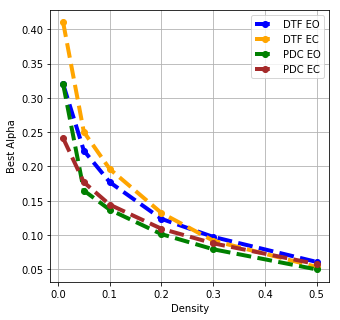

In [79]:
plt.figure(figsize=(5,5))
plt.plot(density_list, best_alpha_obj['alpha_dtf_eo'], "--o", linewidth=4.0, color="blue")
plt.plot(density_list, best_alpha_obj['alpha_dtf_ec'], "--o", linewidth=4.0, color="orange")
plt.plot(density_list, best_alpha_obj['alpha_pdc_eo'], "--o", linewidth=4.0, color="green")
plt.plot(density_list, best_alpha_obj['alpha_pdc_ec'], "--o", linewidth=4.0, color="brown")
plt.grid()
plt.xlabel('Density', fontsize=10)
plt.ylabel('Best Alpha', fontsize=10)
plt.legend(["DTF EO", "DTF EC", 
            "PDC EO", "PDC EC"], fontsize=10, ncol=1)
plt.savefig( cor_dir + "/alpha_density.png", format="png")
plt.show()

## Topological representation of the graph using both PDC and DTF

#### Getting position data

In [80]:
locations_file = Path(os.path.join(my_path, "data/channel_locations_old.txt"))
position_data = create_position_graph(locations_file)

#### Creating graphs using networkx using data from both PDC and DTF

In [81]:
# Creating graphs for DTF
for aObj in best_alpha_obj['dtf']:
   
    #Graph for open case
    dtf_graph_open = create_directed_graph(input_matrix=matrix_open_dtf,
                                                alpha=aObj['alpha_open'],
                                                position=position_data)

    #Graph for closed case
    dtf_graph_closed = create_directed_graph(input_matrix=matrix_closed_dtf,
                                                  alpha=aObj['alpha_closed'],
                                                  position=position_data)
    
    aObj['open_graph'] = dtf_graph_open
    aObj['close_graph'] = dtf_graph_closed
    

# Creating graphs for PDC

for aObj in best_alpha_obj['pdc']:
   
    #Graph for open case
    pdc_graph_open = create_directed_graph(input_matrix=matrix_open_pdc,
                                                alpha=aObj['alpha_open'],
                                                position=position_data)

    #Graph for closed case
    pdc_graph_closed = create_directed_graph(input_matrix=matrix_closed_pdc,
                                                  alpha=aObj['alpha_closed'],
                                                  position=position_data)
    
    aObj['open_graph'] = pdc_graph_open
    aObj['close_graph'] = pdc_graph_closed
    


## Topological representations for DTF and PDC

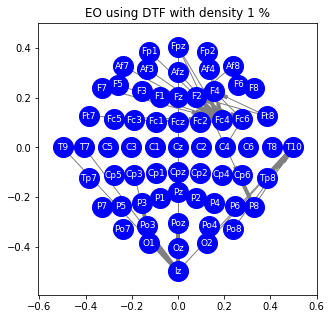

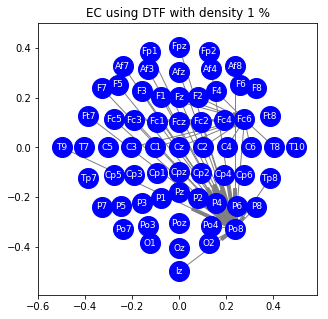

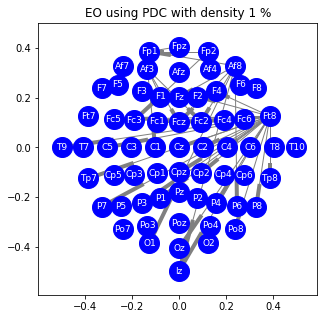

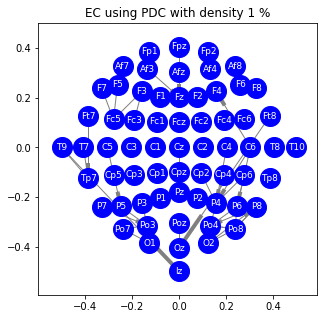

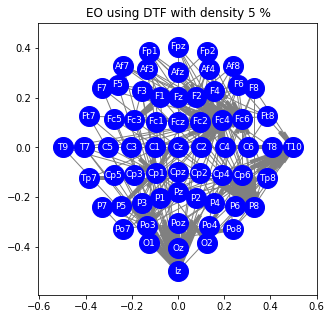

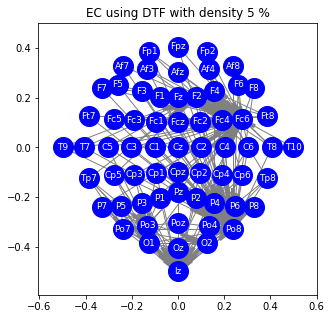

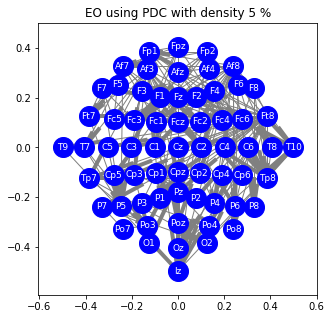

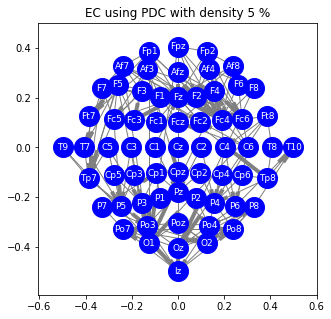

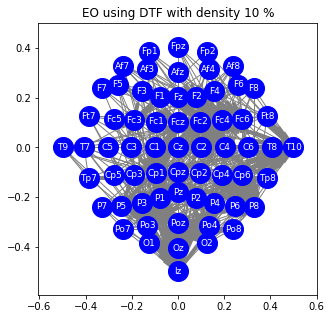

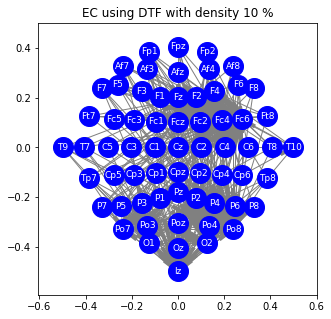

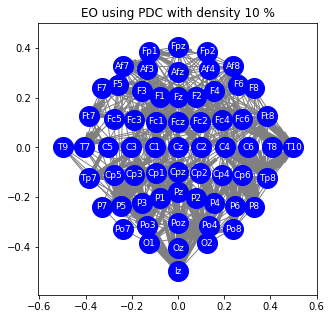

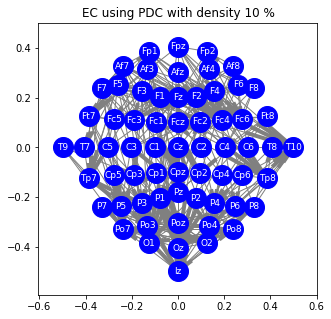

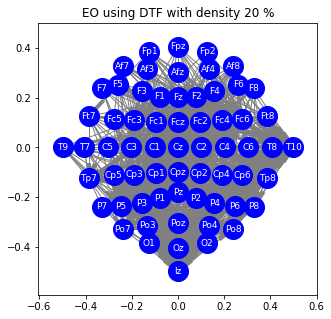

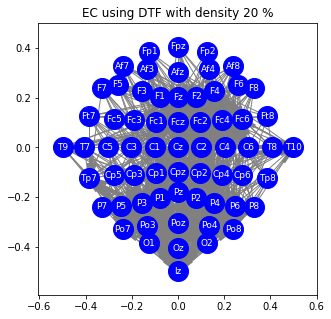

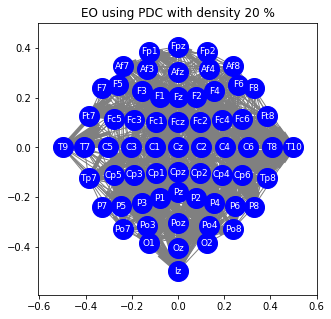

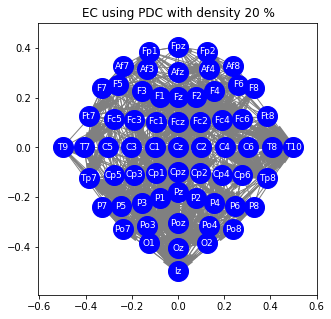

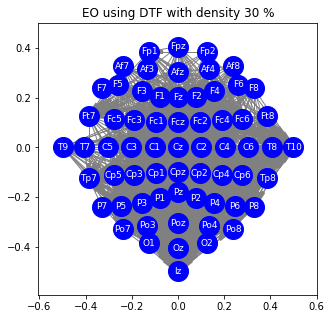

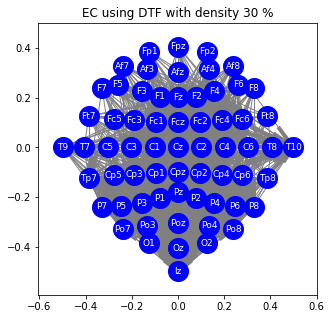

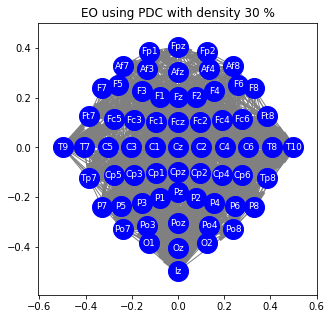

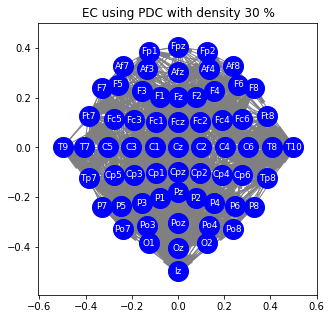

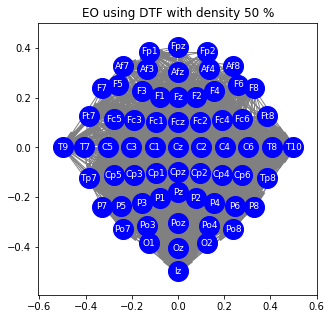

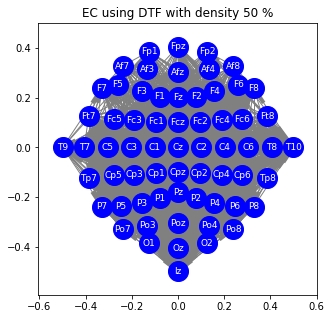

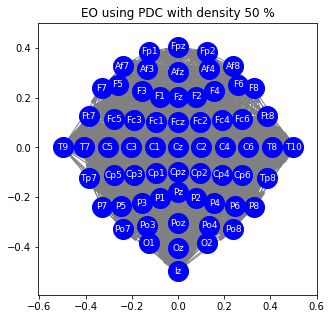

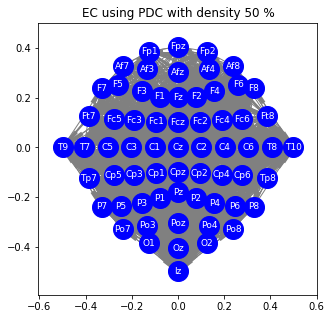

In [82]:
for i in range(len(density_list)):

    cur_dtf = best_alpha_obj['dtf'][i]
    cur_pdc = best_alpha_obj['pdc'][i]
    
    cur_density = cur_dtf['density']
    cur_d_text = str(int(cur_density * 100))
    
    
    # DTF graphs
    
    # Eyes open
    plot_topology(cur_dtf['open_graph'], 0, 0, cur_d_text)
    

    # Eyes close
    plot_topology(cur_dtf['close_graph'], 0, 1, cur_d_text)
    
    
    # PDC graphs
    
    # Eyes open
    plot_topology(cur_pdc['open_graph'], 1, 0, cur_d_text)

    
    # Eyes close
    plot_topology(cur_pdc['close_graph'], 1, 1, cur_d_text)
    

### Drawing the adjacency matrixes for both DTF and PDC

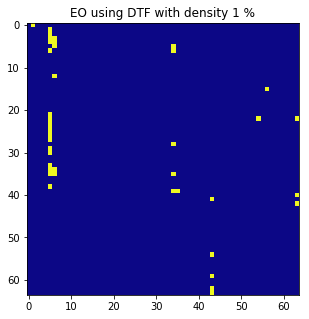

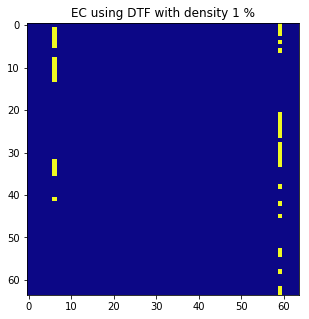

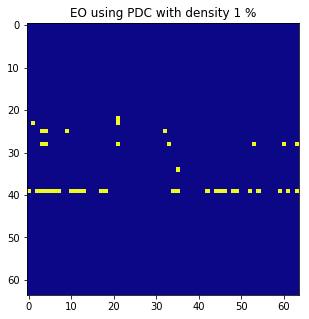

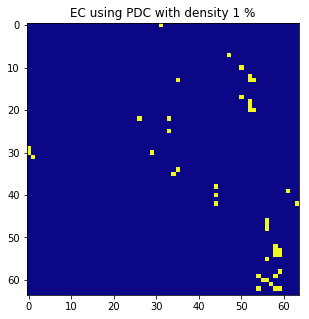

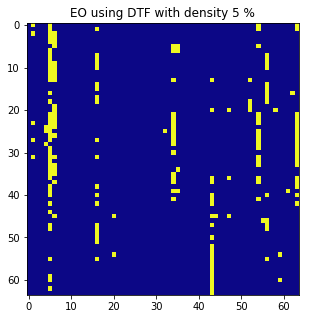

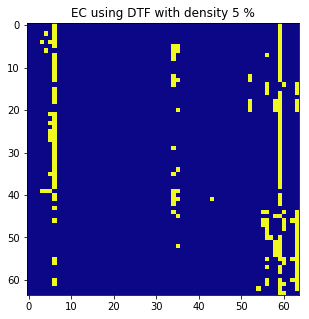

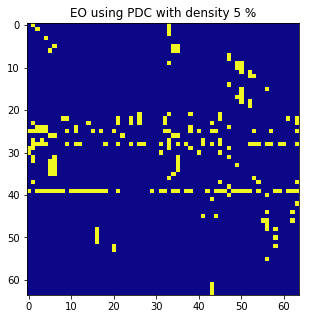

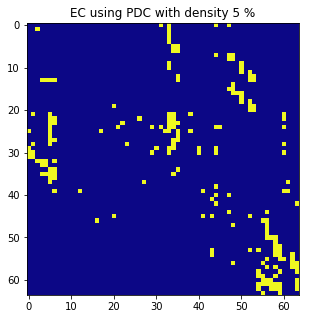

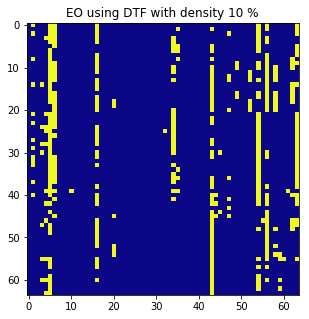

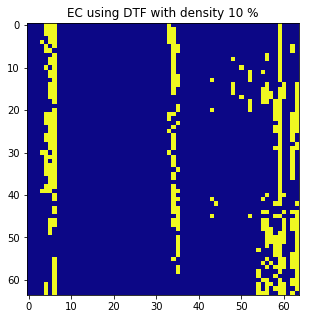

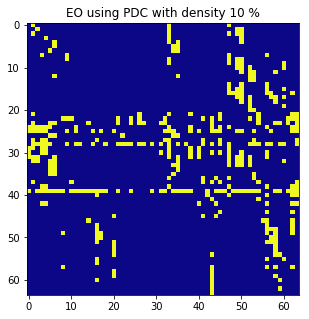

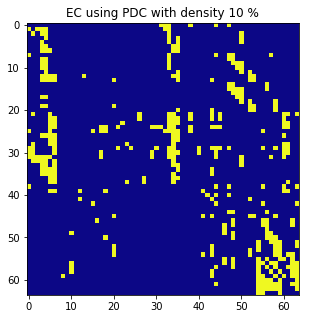

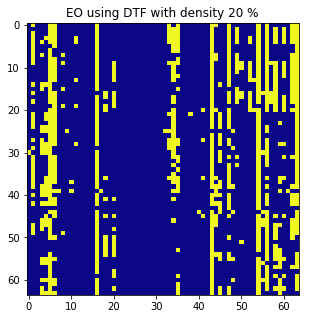

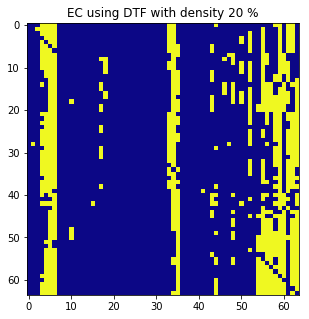

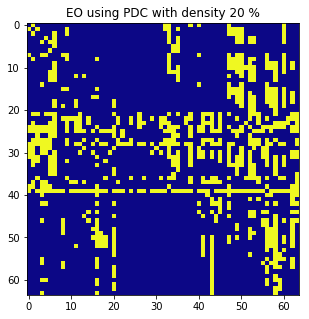

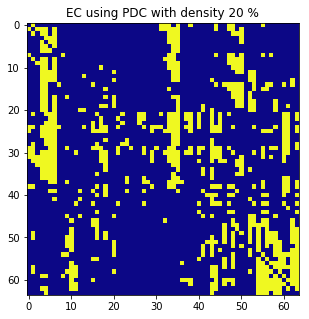

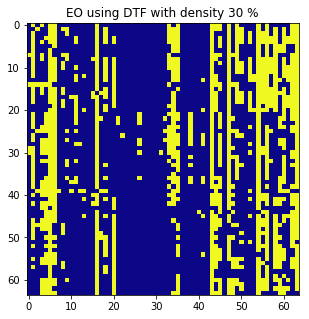

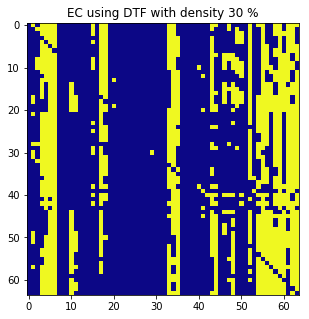

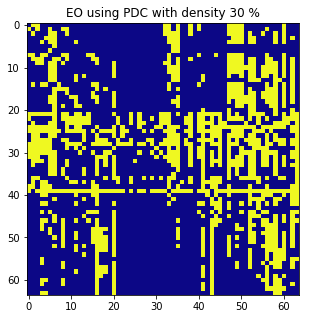

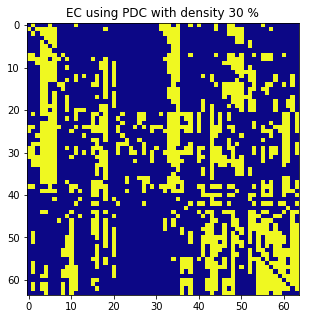

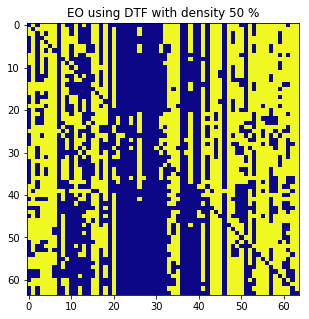

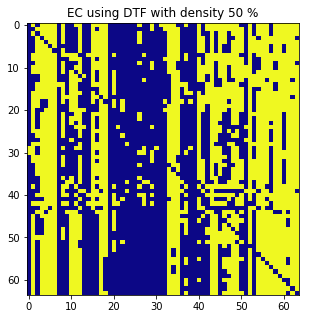

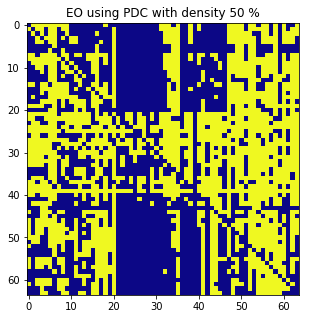

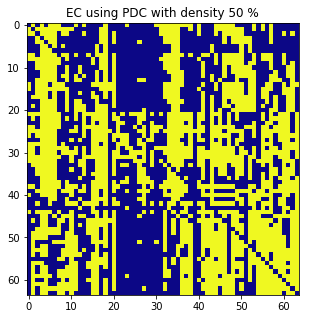

In [83]:

for i in range(len(density_list)):

    cur_dtf = best_alpha_obj['dtf'][i]
    cur_pdc = best_alpha_obj['pdc'][i]
    
    cur_density = cur_dtf['density']
    cur_d_text = str(int(cur_density * 100))
    
    # For DTF

    #Computing binary matrix for open case
    dtf_matrix_open = create_adjacency_matrix(matrix_open_dtf, cur_dtf['alpha_open'])
    
    cur_dtf['open_graph_matrix'] = dtf_matrix_open

    #Computing binary matrix for closed case
    dtf_matrix_closed = create_adjacency_matrix(matrix_closed_dtf, cur_dtf['alpha_closed'])
    
    cur_dtf['close_graph_matrix'] = dtf_matrix_closed
    
    
    plot_adjacency_matrix(dtf_matrix_open, 0,0, cur_d_text)
    
    plot_adjacency_matrix(dtf_matrix_closed, 0,1, cur_d_text)
    
    
    # For PDC

    #Computing binary matrix for open case
    pdc_matrix_open = create_adjacency_matrix(matrix_open_pdc, cur_pdc['alpha_open'])
    
    cur_pdc['open_graph_matrix'] = pdc_matrix_open

    #Computing binary matrix for closed case
    pdc_matrix_closed = create_adjacency_matrix(matrix_closed_pdc, cur_pdc['alpha_closed'])
    
    cur_pdc['close_graph_matrix'] = pdc_matrix_closed
    
    plot_adjacency_matrix(pdc_matrix_open, 1,0, cur_d_text)
    
    plot_adjacency_matrix(pdc_matrix_closed, 1,1, cur_d_text)
    

## Considering the subset of 19 channels suggested in Figure 1 and Table 2, estimate the connectivity using PDC or DTF and apply a statistical validation method (asymptotic statistics 7 , resampling procedure 8 ,...) to filter out values that are not significantly different from 0 ( P DC(i, j ) = / 0 with p < 5 % ).

In [84]:
reduced_set=["Fp1", "Fp2", "F7", "F3", "Fz", "F4", "F8", "T7", "C3", "Cz", "C4", "T8", "P7", "P3", "Pz", "P4", "P8", "O1", "O2"]

reduced_set=["Fp1.", "Fp2."] + [i+".." for i in reduced_set[2:]]

signal_labels19=[i for i in range(len(signal_labels)) if signal_labels[i] in reduced_set]

In [85]:
signal_labels19

[8, 10, 12, 21, 23, 29, 31, 33, 35, 37, 40, 41, 46, 48, 50, 52, 54, 60, 62]

In [86]:
print(reduced_set)

['Fp1.', 'Fp2.', 'F7..', 'F3..', 'Fz..', 'F4..', 'F8..', 'T7..', 'C3..', 'Cz..', 'C4..', 'T8..', 'P7..', 'P3..', 'Pz..', 'P4..', 'P8..', 'O1..', 'O2..']


In [87]:
signal_open19 = signals[signal_labels19,:,0]
signal_closed19 = signals[signal_labels19,:,1]


# Obtaining best order p

# assign static class cp.Mvar to variable mv
mv = cp.Mvar

# Using Vieira-Morf algorithm to find the best model

# For eyes open
best_open19, crit = mv.order_akaike(signal_open19, 15, 'vm')
print(best_open19)

# For eyes closed
best_closed19, crit = mv.order_akaike(signal_closed19, 15, 'vm')
print(best_closed19)

12
15


In [88]:
# Transforming matrix to connectivipy 
data_open19 = cp.Data(data=signal_open19, 
                  fs=frequency_open,
                  chan_names=reduced_set)

data_closed19 = cp.Data(data=signal_closed19, 
                  fs=frequency_closed,
                  chan_names=reduced_set)

# Fitting the mvar model using Yule-Walker algorithm
data_closed19.fit_mvar(best_closed, 'yw')
data_open19.fit_mvar(best_open, 'yw')

av_open19, vf_open19 = data_open19.mvar_coefficients
av_closed19, vf_closed19 = data_closed19.mvar_coefficients

In [ ]:
#We now fit the model for both open and closed using DTF algorithm
dtf = cp.conn.DTF()

# Eyes open
dtfval_open19 = dtf.calculate(av_open19, vf_open19, frequency_open)

# Eyes closed
dtfval_closed19 = dtf.calculate(av_closed19, vf_closed19, frequency_closed)


# EO
matrix_open_dtf19 = dtfval_open19[int(best_frequency), :, :].reshape((64, 64))
np.fill_diagonal(matrix_open_dtf19, 0)

#EC
matrix_closed_dtf19 = dtfval_closed19[int(best_frequency), :, :].reshape((64, 64))
np.fill_diagonal(matrix_closed_dtf19, 0)

In [ ]:
dtf19_significance_eo = dtfval_open19.significance(matrix_open_dtf19, Nrep=100, alpha=0.05, method="yw")
dtf19_significance_ec = dtfval_closed19.significance(matrix_closed_dtf19, Nrep=100, alpha=0.05, method="yw")

In [ ]:
matrix_open_dtf19[dtf19_significance_eo<0.05] = 0
matrix_closed_dtf19[dtf19_significance_ec<0.05] = 0

In [ ]:
matrix_closed_dtf19.shape

# Graph theory indices <a name="5"></a>

### 3.1) Compute binary global (clustering coefficient, path length) and local (degree, in/out-degree) graph indices. List the highest 10 channels for local indices.

In [90]:
# Setting folder paths for graph indices

gi_root_dir = os.path.join(my_path, "data/graph_indices") 

# Relative paths for degree directory
gid_dir = os.path.join(my_path, "data/graph_indices/degree") 
gid_dtf_eo_dir = os.path.join(my_path, "data/graph_indices/degree/dtf/eo")
gid_dtf_ec_dir = os.path.join(my_path, "data/graph_indices/degree/dtf/ec")
gid_pdc_eo_dir = os.path.join(my_path, "data/graph_indices/degree/pdc/eo")
gid_pdc_ec_dir = os.path.join(my_path, "data/graph_indices/degree/pdc/ec")

# Relative paths for in-degree directory
giid_dir = os.path.join(my_path, "data/graph_indices/in-degree") 
giid_dtf_eo_dir = os.path.join(my_path, "data/graph_indices/in-degree/dtf/eo")
giid_dtf_ec_dir = os.path.join(my_path, "data/graph_indices/in-degree/dtf/ec")
giid_pdc_eo_dir = os.path.join(my_path, "data/graph_indices/in-degree/pdc/eo")
giid_pdc_ec_dir = os.path.join(my_path, "data/graph_indices/in-degree/pdc/ec")

# Relative paths for out-degree directory
giod_dir = os.path.join(my_path, "data/graph_indices/out-degree") 
giod_dtf_eo_dir = os.path.join(my_path, "data/graph_indices/out-degree/dtf/eo")
giod_dtf_ec_dir = os.path.join(my_path, "data/graph_indices/out-degree/dtf/ec")
giod_pdc_eo_dir = os.path.join(my_path, "data/graph_indices/out-degree/pdc/eo")
giod_pdc_ec_dir = os.path.join(my_path, "data/graph_indices/out-degree/pdc/ec")

#Correlation Directory
g_local_corr_dir = os.path.join(my_path, "data/graph_indices/correlation/local")
g_global_corr_dir = os.path.join(my_path, "data/graph_indices/correlation/global")



In [91]:
global_df_dict = {}

local_coefs = {
    'in_degree': {
        'dtf_eo': [],
        'dtf_ec': [],
        'pdc_eo': [],
        'pdc_ec': []
    },
    'out_degree': {
        'dtf_eo': [],
        'dtf_ec': [],
        'pdc_eo': [],
        'pdc_ec': []
    },
    'degree': {
        'dtf_eo': [],
        'dtf_ec': [],
        'pdc_eo': [],
        'pdc_ec': []
    }
}

global_coefs = {
    'clustering_quo': {
        'dtf_eo': [],
        'dtf_ec': [],
        'pdc_eo': [],
        'pdc_ec': []
    },
    'average_path': {
        'dtf_eo': [],
        'dtf_ec': [],
        'pdc_eo': [],
        'pdc_ec': []
    }
}

def return_max_value(l):
    return list(l[0])[1]
    

for i in range(len(density_list)):
    
    cur_density = density_list[i]

    cur_dtf = best_alpha_obj['dtf'][i]
    cur_pdc = best_alpha_obj['pdc'][i]


    g_dtf_eo = cur_dtf['open_graph']
    g_dtf_ec = cur_dtf['close_graph']

    g_pdc_eo = cur_pdc['open_graph']
    g_pdc_ec = cur_pdc['close_graph']
    
    clustering_dtf_eo, path_dtf_eo = compute_global(g_dtf_eo)
    clustering_dtf_ec, path_dtf_ec = compute_global(g_dtf_ec)

    clustering_pdc_eo, path_pdc_eo = compute_global(g_pdc_eo)
    clustering_pdc_ec, path_pdc_ec = compute_global(g_pdc_ec)
    
    res_global = {
                    "DTF_EO": {"clust": clustering_dtf_eo , "path": path_dtf_eo}, 
                    "DTF_EC": {"clust": clustering_dtf_ec , "path": path_dtf_ec},
                    "PDC_EO": {"clust": clustering_pdc_eo , "path": path_pdc_eo},
                    "PDC_EC": {"clust": clustering_pdc_ec , "path": path_pdc_ec}
                }
    
    global_df = pd.DataFrame(res_global).T
    global_df_dict[cur_density] = global_df
    
    nx.draw(g_dtf_eo)
    
    
    d_eo, d_in_eo, d_out_eo = compute_local(g_dtf_eo)
    d_ec, d_in_ec, d_out_ec = compute_local(g_dtf_ec)
    
    cur_dtf['open_degree'] = d_eo
    cur_dtf['open_in_degree'] = d_in_eo
    cur_dtf['open_out_degree'] = d_out_eo
    
    cur_dtf['close_degree'] = d_ec
    cur_dtf['close_in_degree'] = d_in_ec
    cur_dtf['close_out_degree'] = d_out_ec
    
    
    p_eo, p_in_eo, p_out_eo = compute_local(g_pdc_eo)
    p_ec, p_in_ec, p_out_ec = compute_local(g_pdc_ec)
    
    cur_pdc['open_degree'] = p_eo
    cur_pdc['open_in_degree'] = p_in_eo
    cur_pdc['open_out_degree'] = p_out_eo
    
    cur_pdc['close_degree'] = p_ec
    cur_pdc['close_in_degree'] = p_in_ec
    cur_pdc['close_out_degree'] = p_out_ec
    
    # Preparing local coefficients meta for correlation
    local_coefs['in_degree']['dtf_eo'].append(return_max_value(d_in_eo))
    local_coefs['in_degree']['dtf_ec'].append(return_max_value(d_in_ec))
    local_coefs['in_degree']['pdc_eo'].append(return_max_value(p_in_eo))
    local_coefs['in_degree']['pdc_ec'].append(return_max_value(p_in_ec))
    
    local_coefs['out_degree']['dtf_eo'].append(return_max_value(d_out_eo))    
    local_coefs['out_degree']['dtf_ec'].append(return_max_value(d_out_ec))
    local_coefs['out_degree']['pdc_eo'].append(return_max_value(d_out_eo))
    local_coefs['out_degree']['pdc_ec'].append(return_max_value(d_out_ec))
    
    local_coefs['degree']['dtf_eo'].append(return_max_value(d_eo))
    local_coefs['degree']['dtf_ec'].append(return_max_value(d_ec))
    local_coefs['degree']['pdc_eo'].append(return_max_value(d_eo))
    local_coefs['degree']['pdc_ec'].append(return_max_value(d_ec))
    
    
    global_coefs['clustering_quo']['dtf_eo'].append(clustering_dtf_eo)
    global_coefs['clustering_quo']['dtf_ec'].append(clustering_dtf_ec)
    global_coefs['clustering_quo']['pdc_eo'].append(clustering_pdc_eo)
    global_coefs['clustering_quo']['pdc_ec'].append(clustering_pdc_ec)
    
    global_coefs['average_path']['dtf_eo'].append(path_dtf_eo)    
    global_coefs['average_path']['dtf_ec'].append(path_dtf_ec)
    global_coefs['average_path']['pdc_eo'].append(path_pdc_eo)
    global_coefs['average_path']['pdc_ec'].append(path_pdc_ec)
    
    d_local_eo = (process_local(d_eo, d_in_eo, d_out_eo))[:10]
    d_local_ec = (process_local(d_ec, d_in_ec, d_out_ec))[:10]
    
    p_local_eo = (process_local(p_eo, p_in_eo, p_out_eo))[:10]
    p_local_ec = (process_local(p_ec, p_in_ec, p_out_ec))[:10]
    
    print("====================================================")
    
    print("For graph desity: " + str(int(cur_density * 100)) + "%")
    print("----------------------------------------------------")
    print("For DTF:")
    print("----------------------------------------------------")
    print("Top 10 channels for Eyes open: ")
    print("----------------------------------------------------")
    print(d_local_eo)
    print("----------------------------------------------------")
    print("Top 10 channels for Eyes closed: ")
    print("----------------------------------------------------")
    print(d_local_ec)
    print("----------------------------------------------------")
    
    print("For PDC:")
    print("----------------------------------------------------")
    print("Top 10 channels for Eyes open: ")
    print("----------------------------------------------------")
    print(p_local_eo)
    print("----------------------------------------------------")
    print("Top 10 channels for Eyes closed: ")
    print("----------------------------------------------------")
    print(p_local_ec)
    
    print("====================================================")
    
    

For graph desity: 1%
----------------------------------------------------
For DTF:
----------------------------------------------------
Top 10 channels for Eyes open: 
----------------------------------------------------
      degree  in_degree  out_degree
Fc4.      20         18           2
Fc6.       8          6           2
F2..       7          5           2
T10.       5          5           0
F4..       4          1           3
Iz..       4          3           1
Fpz.       3          0           3
Fc3.       2          1           1
Fcz.       2          0           2
Fc2.       2          0           2
----------------------------------------------------
Top 10 channels for Eyes closed: 
----------------------------------------------------
      degree  in_degree  out_degree
Po8.      25         25           0
Fc6.      17         16           1
Fc3.       2          0           2
Fc1.       2          0           2
Fc2.       2          0           2
F1..       2          0    

For graph desity: 30%
----------------------------------------------------
For DTF:
----------------------------------------------------
Top 10 channels for Eyes open: 
----------------------------------------------------
      degree  in_degree  out_degree
Cp1.      86         61          25
P8..      79         62          17
P5..      77         56          21
Iz..      77         61          16
Fc4.      76         61          15
Po3.      73         56          17
T10.      70         62           8
Fc6.      66         52          14
Fc3.      65         43          22
O1..      61         40          21
----------------------------------------------------
Top 10 channels for Eyes closed: 
----------------------------------------------------
      degree  in_degree  out_degree
Fc6.      80         63          17
Po7.      79         60          19
Cpz.      78         54          24
Po8.      78         62          16
Fc4.      77         61          16
Iz..      74         55   

In [92]:
for i in range(len(density_list)):
    
    print("For graph desity: " + str(cur_density * 100) + "%")
    print("--------------------------------------------------")
    cur_density = density_list[i]
    print(global_df_dict[cur_density])
    print("==================================================")
    
    
    

For graph desity: 50.0%
--------------------------------------------------
           clust      path
DTF_EC  0.136579  2.252252
DTF_EO  0.142990  2.946237
PDC_EC  0.248718  2.358974
PDC_EO  0.052713  2.859175
For graph desity: 1.0%
--------------------------------------------------
           clust      path
DTF_EC  0.791338  2.008433
DTF_EO  0.418772  2.192460
PDC_EC  0.292958  2.877976
PDC_EO  0.303620  2.192460
For graph desity: 5.0%
--------------------------------------------------
           clust      path
DTF_EC  0.700483  1.814484
DTF_EO  0.661004  1.820933
PDC_EC  0.446652  2.122520
PDC_EO  0.365609  1.894841
For graph desity: 10.0%
--------------------------------------------------
           clust      path
DTF_EC  0.754127  1.640873
DTF_EO  0.711346  1.636905
PDC_EC  0.492946  1.653770
PDC_EO  0.507660  1.623512
For graph desity: 20.0%
--------------------------------------------------
           clust      path
DTF_EC  0.781172  1.486607
DTF_EO  0.743793  1.479167
PDC_EC

## Correlation for Local Coefficients

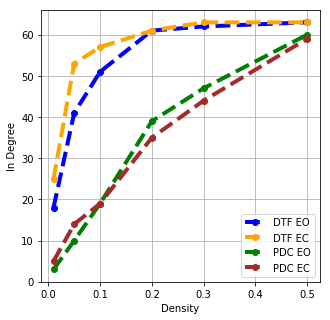

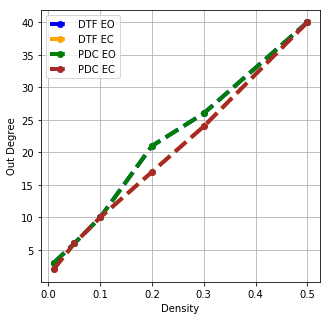

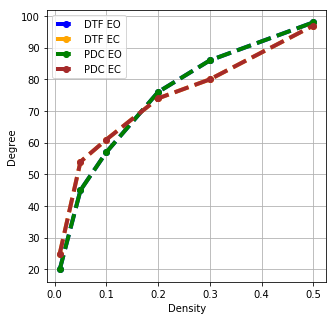

In [107]:

# Correlation for Local Coefficients

plt.figure(figsize=(5,5))
plt.plot(density_list, local_coefs['in_degree']['dtf_eo'], "--o", linewidth=4.0, color="blue")
plt.plot(density_list, local_coefs['in_degree']['dtf_ec'], "--o", linewidth=4.0, color="orange")
plt.plot(density_list, local_coefs['in_degree']['pdc_eo'], "--o", linewidth=4.0, color="green")
plt.plot(density_list, local_coefs['in_degree']['pdc_ec'], "--o", linewidth=4.0, color="brown")
plt.grid()
plt.xlabel('Density', fontsize=10)
plt.ylabel('In Degree', fontsize=10)
plt.legend(["DTF EO", "DTF EC", 
            "PDC EO", "PDC EC"], fontsize=10, ncol=1)
plt.savefig(g_local_corr_dir + "/in_degree.png", format="png")
plt.show()


plt.figure(figsize=(5,5))
plt.plot(density_list, local_coefs['out_degree']['dtf_eo'], "--o", linewidth=4.0, color="blue")
plt.plot(density_list, local_coefs['out_degree']['dtf_ec'], "--o", linewidth=4.0, color="orange")
plt.plot(density_list, local_coefs['out_degree']['pdc_eo'], "--o", linewidth=4.0, color="green")
plt.plot(density_list, local_coefs['out_degree']['pdc_ec'], "--o", linewidth=4.0, color="brown")
plt.grid()
plt.xlabel('Density', fontsize=10)
plt.ylabel('Out Degree', fontsize=10)
plt.legend(["DTF EO", "DTF EC", 
            "PDC EO", "PDC EC"], fontsize=10, ncol=1)
plt.savefig(g_local_corr_dir + "/out_degree.png", format="png")
plt.show()

plt.figure(figsize=(5,5))
plt.plot(density_list, local_coefs['degree']['dtf_eo'], "--o", linewidth=4.0, color="blue")
plt.plot(density_list, local_coefs['degree']['dtf_ec'], "--o", linewidth=4.0, color="orange")
plt.plot(density_list, local_coefs['degree']['pdc_eo'], "--o", linewidth=4.0, color="green")
plt.plot(density_list, local_coefs['degree']['pdc_ec'], "--o", linewidth=4.0, color="brown")
plt.grid()
plt.xlabel('Density', fontsize=10)
plt.ylabel('Degree', fontsize=10)
plt.legend(["DTF EO", "DTF EC", 
            "PDC EO", "PDC EC"], fontsize=10, ncol=1)
plt.savefig(g_local_corr_dir + "/degree.png", format="png")
plt.show()

## Correlation for Global Coefficients

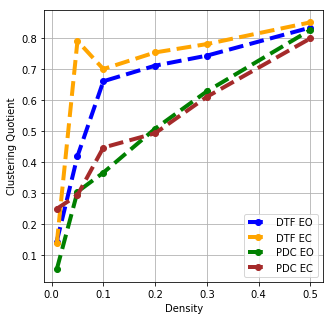

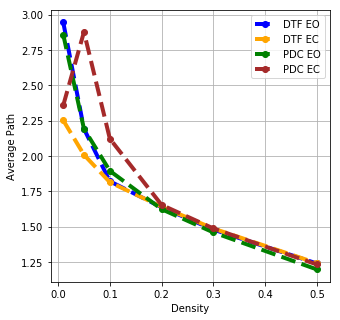

In [94]:
plt.figure(figsize=(5,5))
plt.plot(density_list, global_coefs['clustering_quo']['dtf_eo'], "--o", linewidth=4.0, color="blue")
plt.plot(density_list, global_coefs['clustering_quo']['dtf_ec'], "--o", linewidth=4.0, color="orange")
plt.plot(density_list, global_coefs['clustering_quo']['pdc_eo'], "--o", linewidth=4.0, color="green")
plt.plot(density_list, global_coefs['clustering_quo']['pdc_ec'], "--o", linewidth=4.0, color="brown")
plt.grid()
plt.xlabel('Density', fontsize=10)
plt.ylabel('Clustering Quotient', fontsize=10)
plt.legend(["DTF EO", "DTF EC", 
            "PDC EO", "PDC EC"], fontsize=10, ncol=1)
plt.savefig(g_global_corr_dir + "/clustering_quotient.png", format="png")
plt.show()


plt.figure(figsize=(5,5))
plt.plot(density_list, global_coefs['average_path']['dtf_eo'], "--o", linewidth=4.0, color="blue")
plt.plot(density_list, global_coefs['average_path']['dtf_ec'], "--o", linewidth=4.0, color="orange")
plt.plot(density_list, global_coefs['average_path']['pdc_eo'], "--o", linewidth=4.0, color="green")
plt.plot(density_list, global_coefs['average_path']['pdc_ec'], "--o", linewidth=4.0, color="brown")
plt.grid()
plt.xlabel('Density', fontsize=10)
plt.ylabel('Average Path', fontsize=10)
plt.legend(["DTF EO", "DTF EC", 
            "PDC EO", "PDC EC"], fontsize=10, ncol=1)
plt.savefig(g_global_corr_dir + "/average_path.png", format="png")
plt.show()


### 3.5) Make a topographical representation of local indices

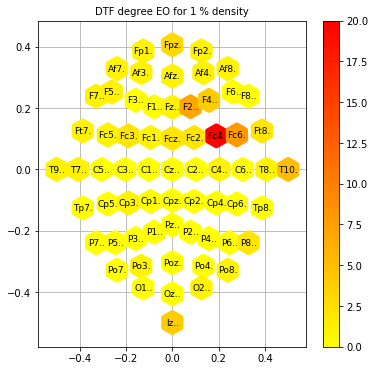

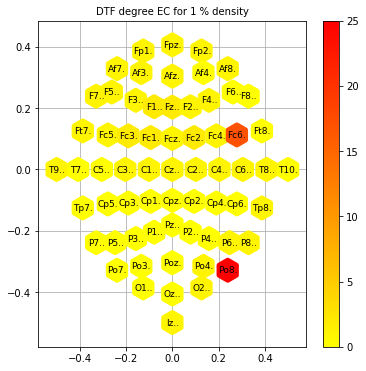

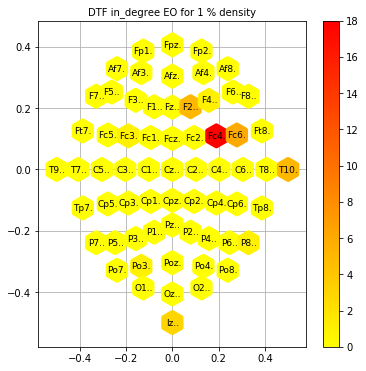

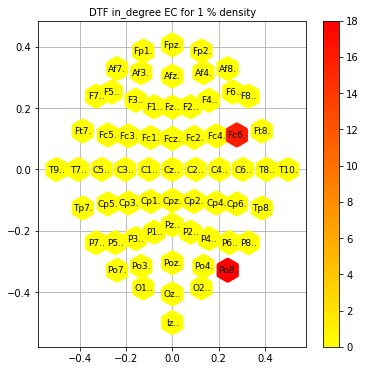

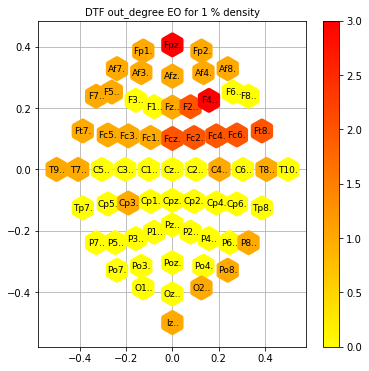

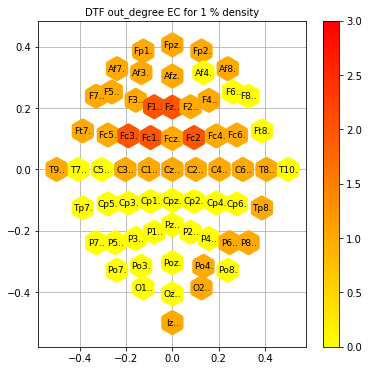

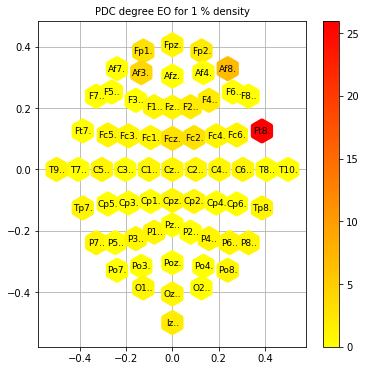

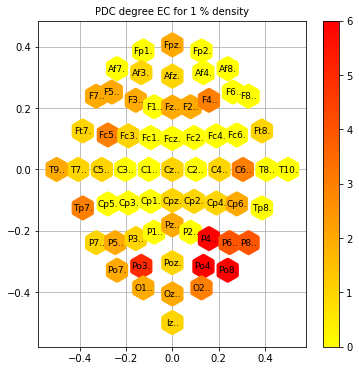

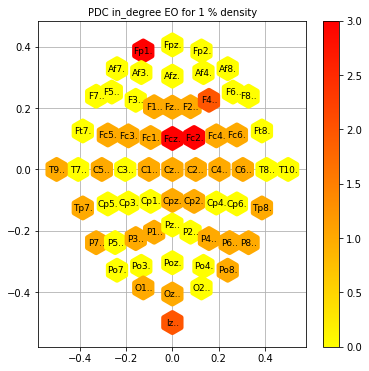

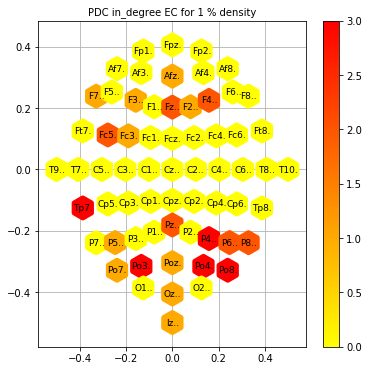

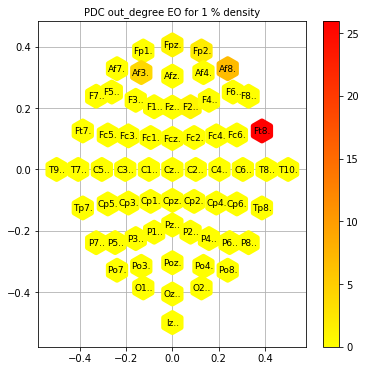

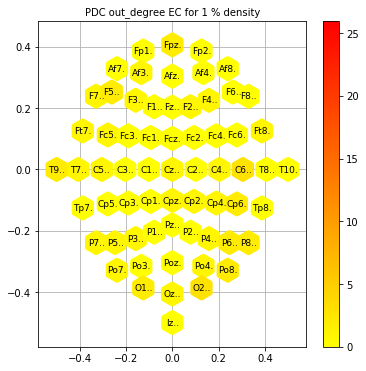

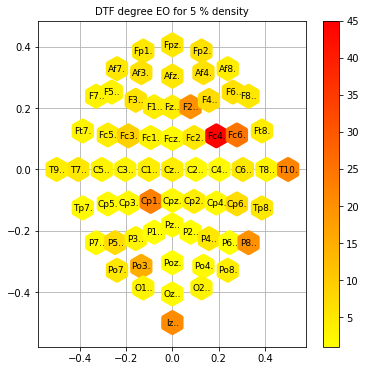

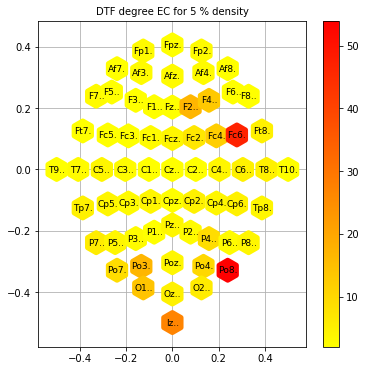

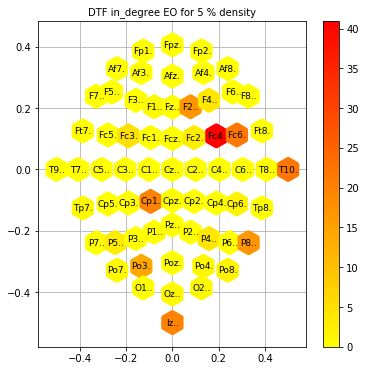

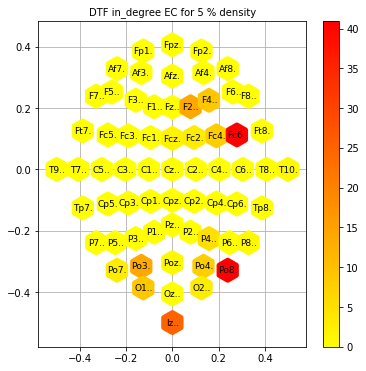

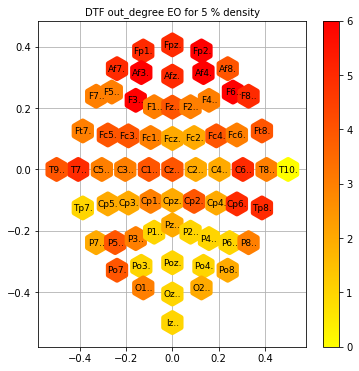

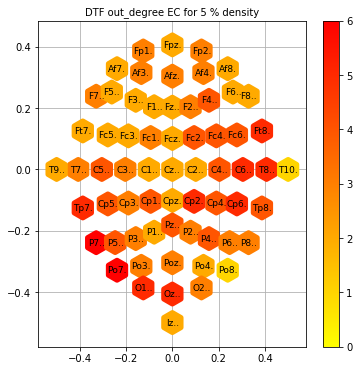

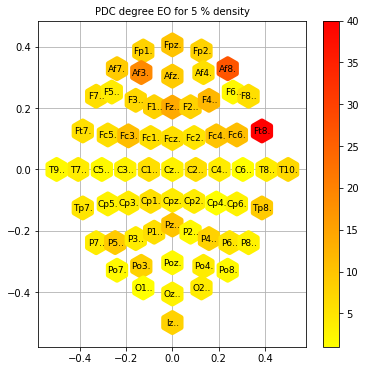

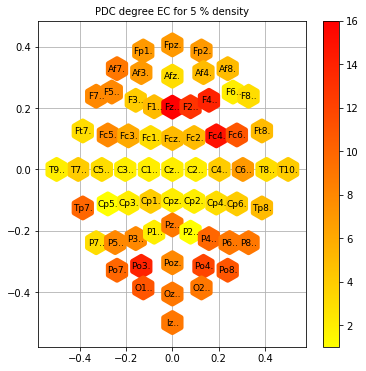

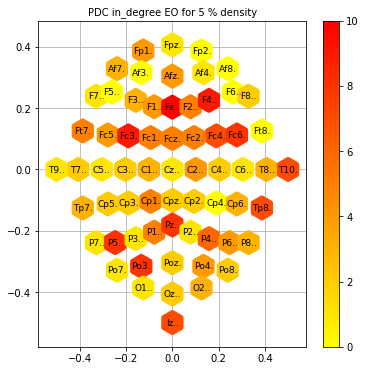

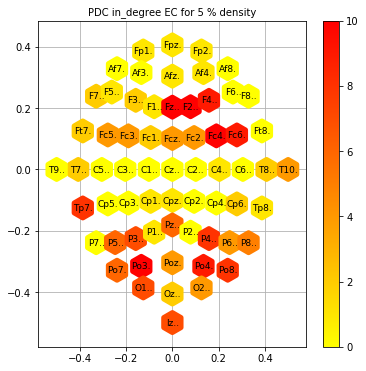

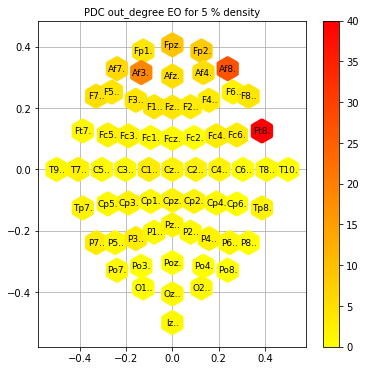

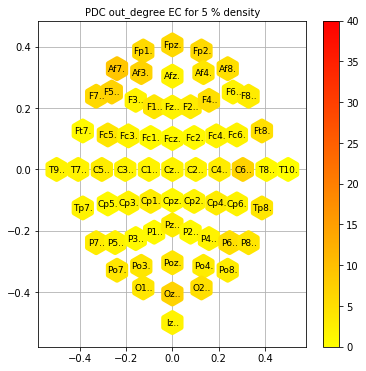

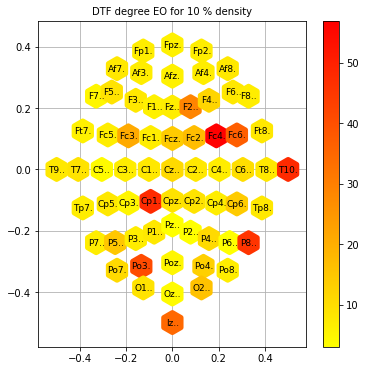

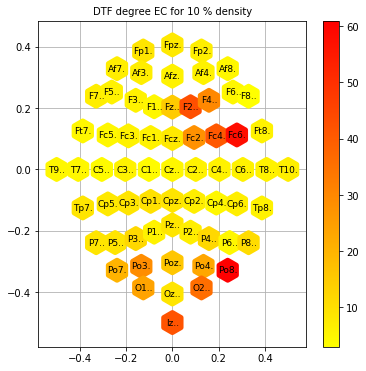

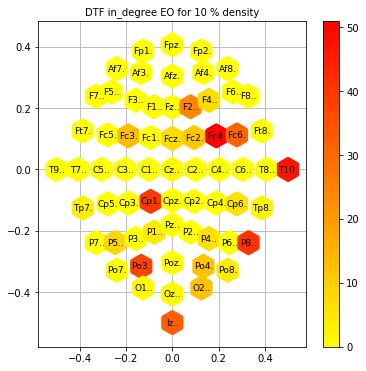

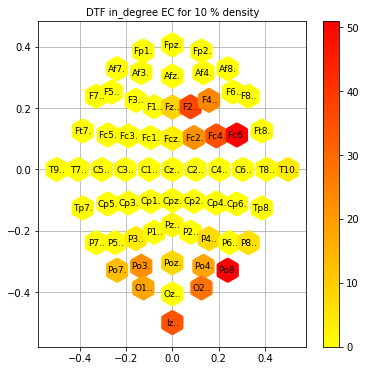

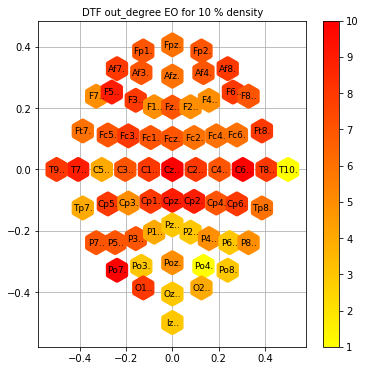

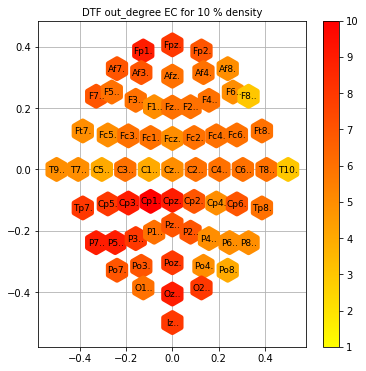

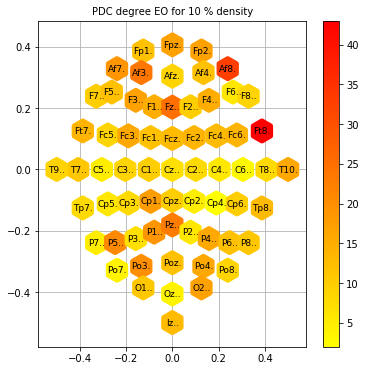

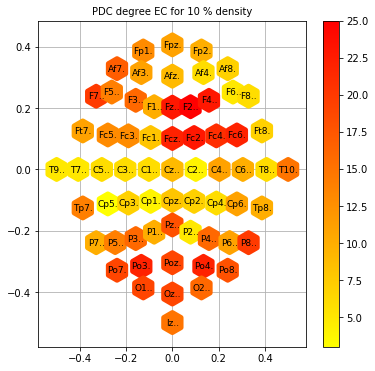

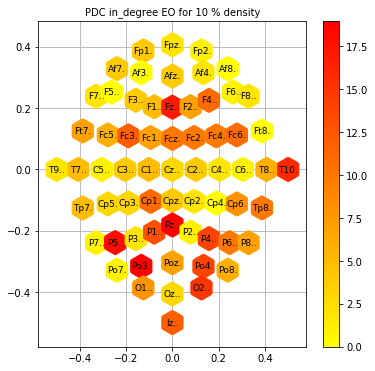

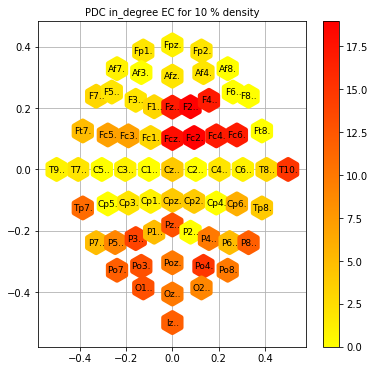

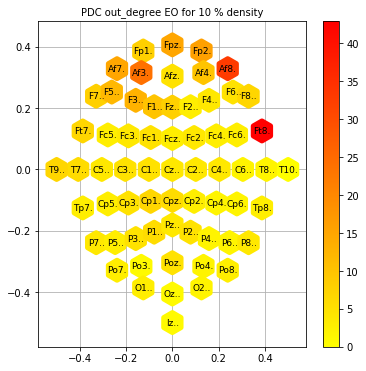

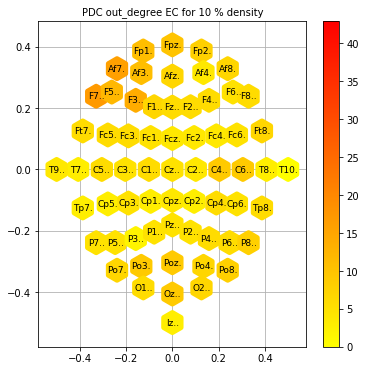

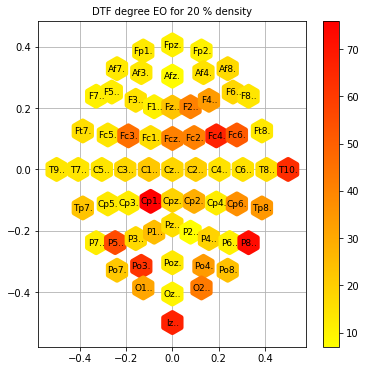

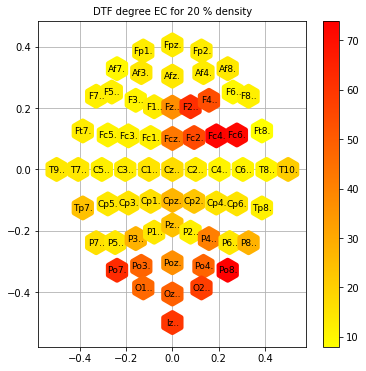

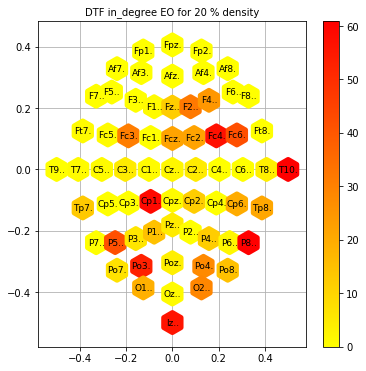

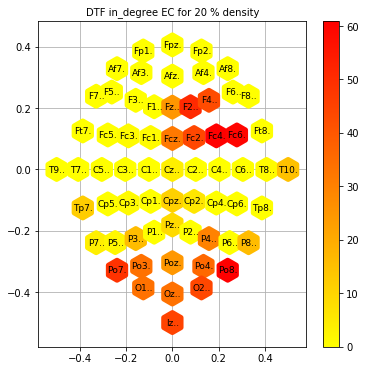

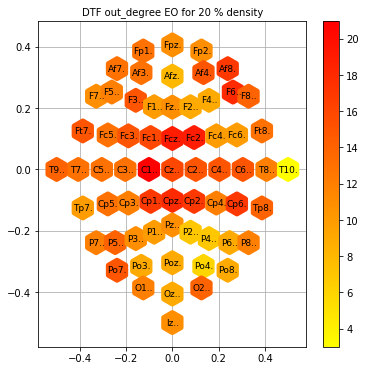

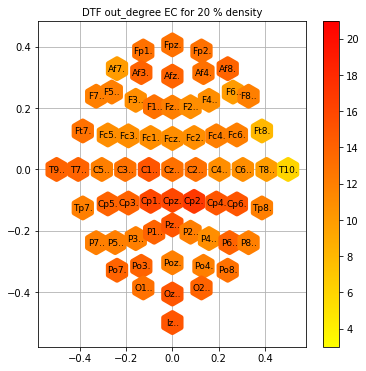

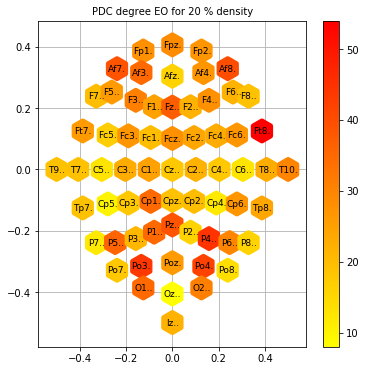

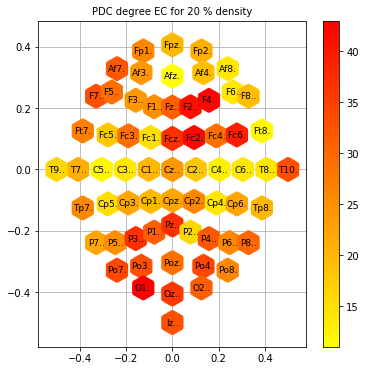

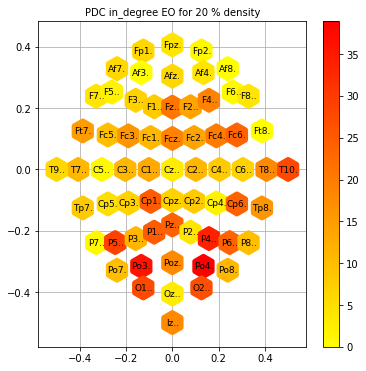

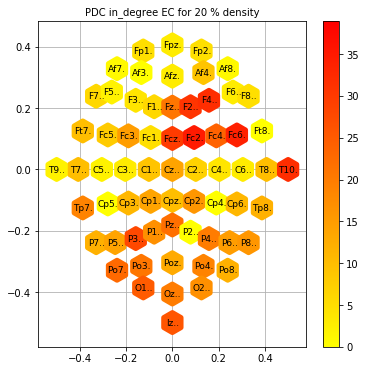

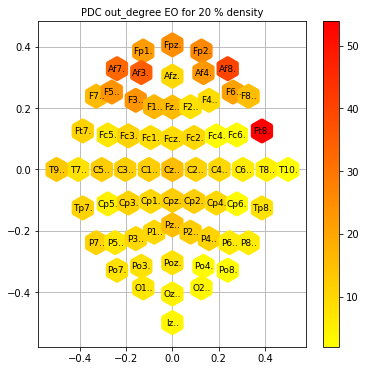

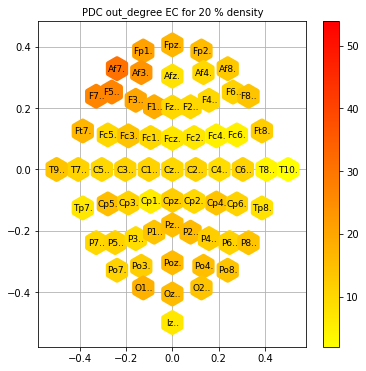

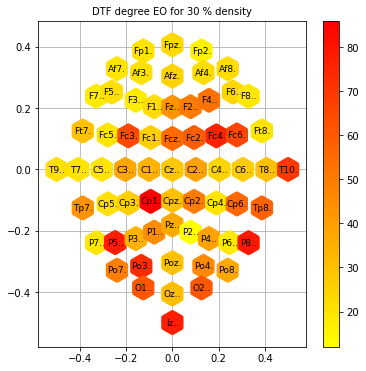

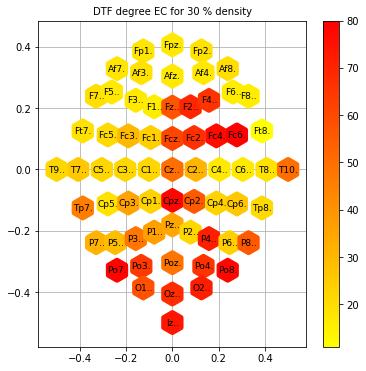

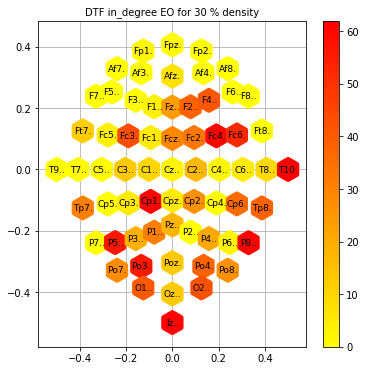

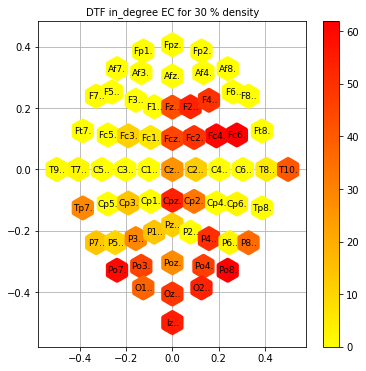

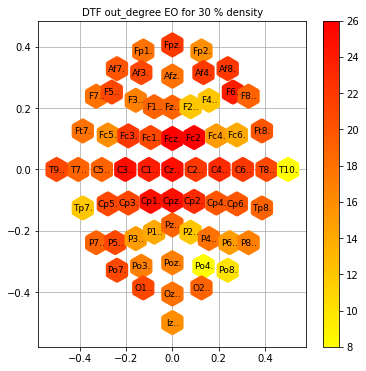

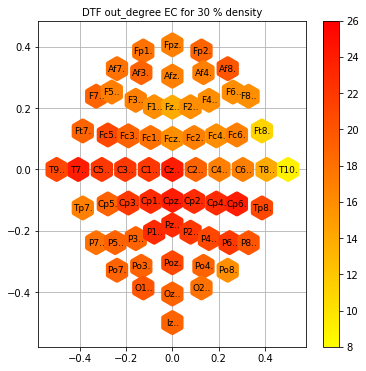

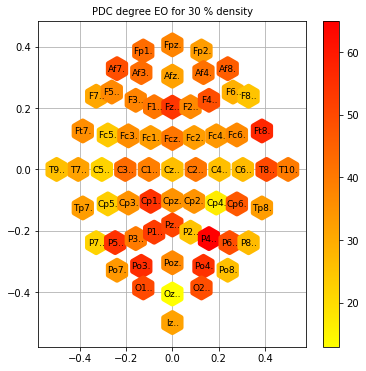

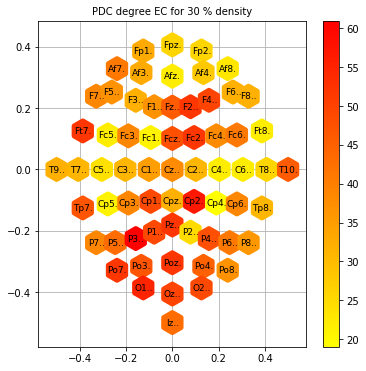

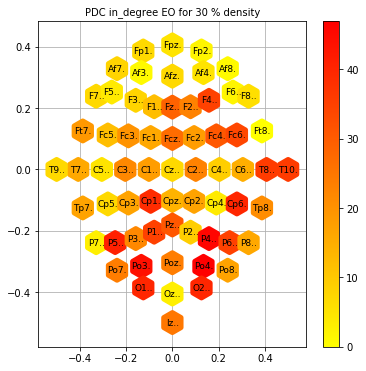

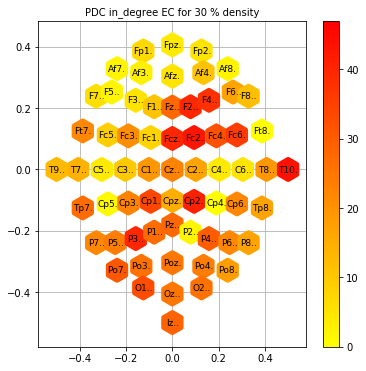

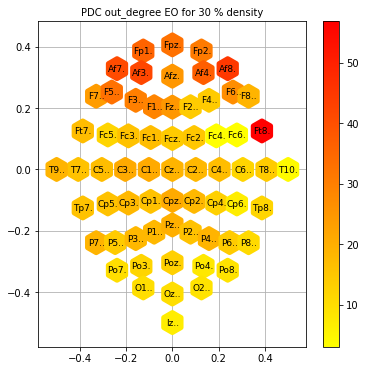

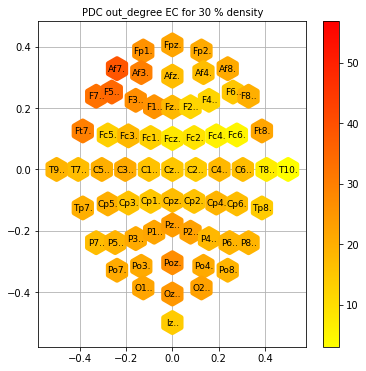

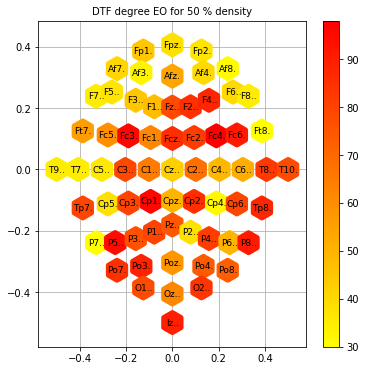

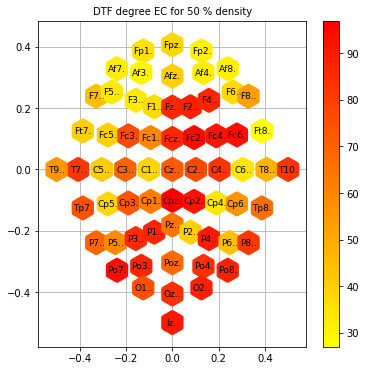

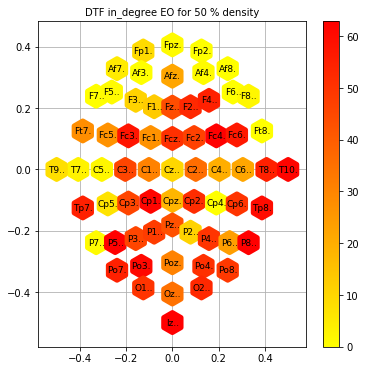

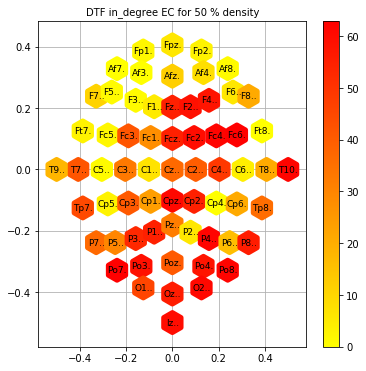

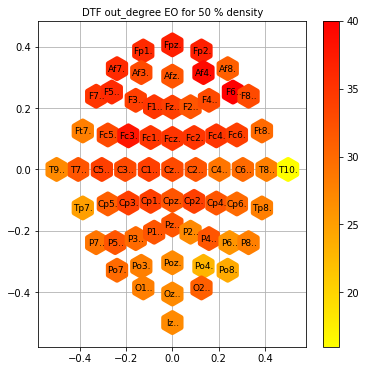

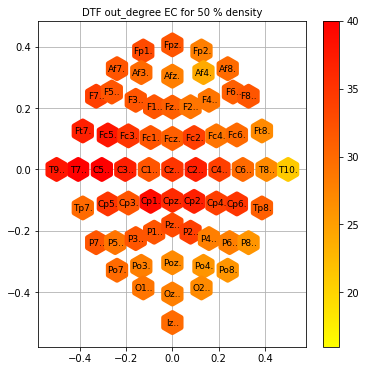

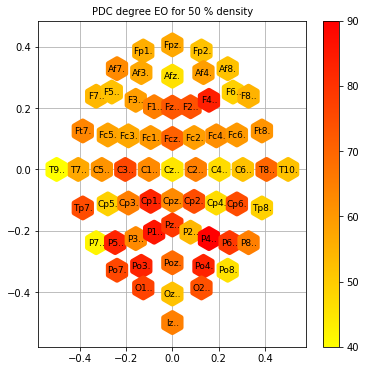

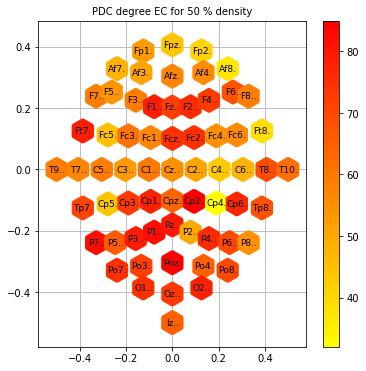

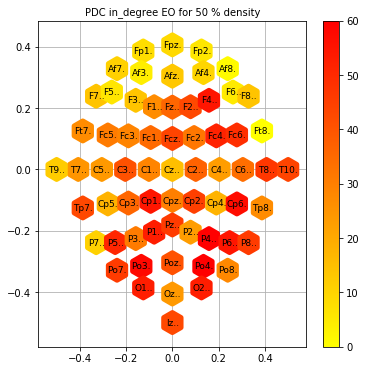

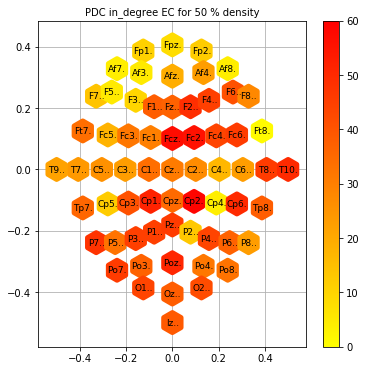

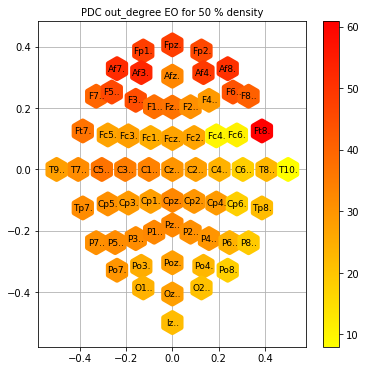

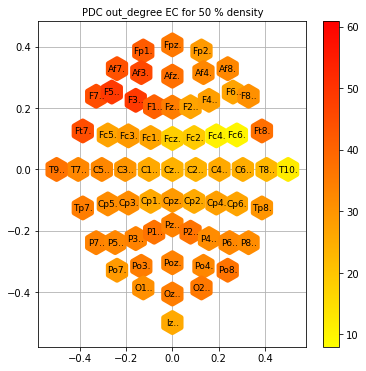

In [95]:
for i in range(len(density_list)):
    
    cur_dtf = best_alpha_obj['dtf'][i]
    cur_pdc = best_alpha_obj['pdc'][i]
    
    cur_density = density_list[i]
    
    g_dtf_eo = nx.DiGraph(cur_dtf['open_graph_matrix'])
    g_dtf_ec = nx.DiGraph(cur_dtf['close_graph_matrix'])

    g_pdc_eo = nx.DiGraph(cur_pdc['open_graph_matrix'])
    g_pdc_ec = nx.DiGraph(cur_pdc['close_graph_matrix'])
    
    
    # Getting local indices using DTF
    
    # Eyes open
    d_eo = format_tuple_common(cur_dtf['open_degree'])
    d_in_eo = format_tuple_common(cur_dtf['open_in_degree'])
    d_out_eo = format_tuple_common(cur_dtf['open_out_degree'])
    
    #print(d_eo)
    
    # Eyes close
    d_ec = format_tuple_common(cur_dtf['close_degree'])
    d_in_ec = format_tuple_common(cur_dtf['close_in_degree'])
    d_out_ec = format_tuple_common(cur_dtf['close_out_degree'])
    
    # Getting local indices using PDC
    
    # Eyes open
    p_eo = format_tuple_common(cur_pdc['open_degree'])
    p_in_eo = format_tuple_common(cur_pdc['open_in_degree']) 
    p_out_eo = format_tuple_common(cur_pdc['open_out_degree'])
    
    # Eyes close
    p_ec = format_tuple_common(cur_pdc['close_degree'])
    p_in_ec = format_tuple_common(cur_pdc['close_in_degree'])
    p_out_ec = format_tuple_common(cur_pdc['close_out_degree'])
    
    # Topographies using DTF
    
    d_color_eo=[i[1] for i in sorted(d_eo)]
    
    density_value = str(int(cur_density * 100))
    
    density_text = " for " + density_value + " % density"
    
    plot_degree_graph(g_dtf_eo, d_color_eo, "DTF degree EO" + density_text, min(d_color_eo), max(d_color_eo), [0,0,0, density_value], True)
    
    d_color_ec=[i[1] for i in sorted(d_ec)]
    plot_degree_graph(g_dtf_ec, d_color_ec, "DTF degree EC" + density_text, min(d_color_ec), max(d_color_ec), [0,0,1, density_value], True)
    
    
    d_color_in_eo=[i[1] for i in sorted(d_in_eo)]
    plot_degree_graph(g_dtf_eo, d_color_in_eo, "DTF in_degree EO" + density_text, min(d_color_in_eo), max(d_color_in_eo), [1,0,0, density_value], True)
    
    d_color_in_ec=[i[1] for i in sorted(d_in_ec)]
    plot_degree_graph(g_dtf_ec, d_color_in_ec, "DTF in_degree EC" + density_text, min(d_color_in_eo), max(d_color_in_eo), [1,0,1, density_value], True)
    
    d_color_out_eo=[i[1] for i in sorted(d_out_eo)]
    plot_degree_graph(g_dtf_eo, d_color_out_eo, "DTF out_degree EO" + density_text, min(d_color_out_eo), max(d_color_out_eo), [2,0,0, density_value], True)
    
    d_color_out_ec=[i[1] for i in sorted(d_out_ec)]
    plot_degree_graph(g_dtf_ec, d_color_out_ec, "DTF out_degree EC" + density_text, min(d_color_out_eo), max(d_color_out_eo), [2,0,1, density_value], True)
    
    
    # Topographies using PDC
    
    p_color_eo=[i[1] for i in sorted(p_eo)]
    plot_degree_graph(g_pdc_eo, p_color_eo, "PDC degree EO" + density_text, min(p_color_eo), max(p_color_eo), [0,1,0, density_value], True)
    
    p_color_ec=[i[1] for i in sorted(p_ec)]
    plot_degree_graph(g_pdc_ec, p_color_ec, "PDC degree EC" + density_text, min(p_color_ec), max(p_color_ec), [0,1,1, density_value], True)
    
    
    p_color_in_eo=[i[1] for i in sorted(p_in_eo)]
    plot_degree_graph(g_pdc_eo, p_color_in_eo, "PDC in_degree EO" + density_text, min(p_color_in_eo), max(p_color_in_eo), [1,1,0, density_value], True)
    
    p_color_in_ec=[i[1] for i in sorted(p_in_ec)]
    plot_degree_graph(g_pdc_ec, p_color_in_ec, "PDC in_degree EC" + density_text, min(p_color_in_eo), max(p_color_in_eo), [1,1,1, density_value], True)
    
    p_color_out_eo=[i[1] for i in sorted(p_out_eo)]
    plot_degree_graph(g_pdc_eo, p_color_out_eo, "PDC out_degree EO" + density_text, min(p_color_out_eo), max(p_color_out_eo), [2,1,0, density_value], True)
    
    p_color_out_ec=[i[1] for i in sorted(p_out_ec)]
    plot_degree_graph(g_pdc_ec, p_color_out_ec, "PDC out_degree EC" + density_text, min(p_color_out_eo), max(p_color_out_eo), [2,1,1, density_value], True)
    

###  Search in the literature a definition of small-worldness index (i.e. an index describing the small-world organization of a network) and compute it.

### small-worldness index  ---> average shortest path ~ log(N)

In [96]:
np.log10(signals.shape[0])

1.806179973983887

In [97]:
G_random_eo = []
G_random_ec = []
for _ in range(100):
    G_random_eo.append(nx.erdos_renyi_graph(n=signals.shape[0], p=nx.density(g_dtf_eo)))
    G_random_ec.append(nx.erdos_renyi_graph(n=signals.shape[0], p=nx.density(g_dtf_ec)))

In [98]:
ClusteringRandom_eo=[]
PathRandom_eo=[]
ClusteringRandom_ec=[]
PathRandom_ec=[]

for i in range(100):
    c_r, p_r = compute_global(G_random_eo[i])
    ClusteringRandom_eo.append(c_r)
    PathRandom_eo.append(p_r)
    
    c_r, p_r = compute_global(G_random_ec[i])
    ClusteringRandom_ec.append(c_r)
    PathRandom_ec.append(p_r)

In [99]:
average_clustering_random_eo = np.mean(ClusteringRandom_eo)
average_clustering_random_ec = np.mean(ClusteringRandom_ec)

average_path_random_eo=np.mean(PathRandom_eo)
average_path_random_ec=np.mean(PathRandom_ec)

In [100]:
res={"clustering":[clustering_dtf_eo, clustering_dtf_ec], 
     "clustering_random": [average_clustering_random_eo, average_clustering_random_ec],
    "path": [path_dtf_eo, path_dtf_ec], "path_random": [average_path_random_eo, average_path_random_ec]}

In [101]:
pd.DataFrame(res)

clustering  clustering_random      path  path_random
0    0.834597           0.500675  1.239087     1.499960
1    0.851385           0.500803  1.241071     1.499013

In [102]:
res=pd.DataFrame(res, index=["EO", "EC"])

In [103]:
sigma=res["clustering"]/res["clustering_random"] / res["path"]/ res["path_random"]

In [104]:
res["sigma"] = sigma

### $\sigma = \frac{C}{C_r} / \frac{P}{P_r}$

In [105]:
sigma > 1

EO    False
EC    False
dtype: bool